In [107]:
# -*- coding: utf-8 -*-
"""
This is a workflow intended to expedite the plotting of flow properties from CenCOOS 2km HF Radar Data
Optimized to run on Eady (eady.caltech.edu)

Please utilize the Dask distributed Client scheduler for best results
Last Updatedd 06/18/2020 Thursday

"""
from IPython.core.display import display, HTML # Widen jupyter notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
# Setup Distributed Client
autostart = True
if autostart:
    pass # just let it use the dask lab extension cluster
else:
    from dask.diagnostics import ProgressBar
    from dask.distributed import Client
    from dask.distributed import LocalCluster
    # client = Client('localhost:8787') # Connect to old dashboard?
    try:
        client = Client('tcp://localhost:8786', timeout='2s')
    except OSError:
        cluster = LocalCluster(scheduler_port=8786)
        client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:46636 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.93 GB


In [24]:
#%% Setup Packages
import xarray as xr
from xarray import open_mfdataset
import dask
import dask.array as da
import netCDF4 as netcdf
import numpy as np
import numpy.ma as ma
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units
import multiprocessing
import copy


import sys
import os
from importlib import reload

sys.path.insert(1,r"/export/home1/jbenjami/Research_Thompson/Python/Personal/")
print(sys.path)
import personal

import personal.math as pm
import personal.data_structures
import personal.date_operations
import personal.SMODE
import personal.calculations


#%% Plot setup
dpi = 100
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

['/export/home1/jbenjami/Research_Thompson/Python', '/export/home1/jbenjami/Research_Thompson/Python/Personal/', '/export/home1/jbenjami/Research_Thompson/Python/Personal/', '/export/home1/jbenjami/anaconda3/lib/python37.zip', '/export/home1/jbenjami/anaconda3/lib/python3.7', '/export/home1/jbenjami/anaconda3/lib/python3.7/lib-dynload', '', '/export/home1/jbenjami/.local/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/export/home1/jbenjami/.ipython']


In [146]:
# Load SMODE Data
file_path        = os.path.abspath(os.path.dirname(''))
data_relpath_2km = "../Data/HF_Radar/2km/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath_2km))

# gradients_HF = xr.open_mfdataset(data_source+'/processed/smode_region/gradients/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",chunks={'time':24},parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speedfor var in smode_data.data_vars: smode_data[var] = smode_data[var].astype('float32')
velocity_HF  = xr.open_mfdataset(data_source+'/processed/smode_region/velocity/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",chunks={'time':24},parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed

In [147]:
# Load LLC4320 Data
file_path        = os.path.abspath(os.path.dirname(''))
data_relpath_2km = "../Data/LLC4320/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath_2km))

# gradients_LLC = xr.open_mfdataset(data_source+'/processed/smode_region/gradients/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",chunks={'time':24},parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speedfor var in smode_data.data_vars: smode_data[var] = smode_data[var].astype('float32')
velocity_LLC  = xr.open_mfdataset(data_source+'/smode_region/velocity/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",chunks={'time':24},parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed

In [ ]:
#%% Plot Vorticity Animation

fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)


ax = plt.axes(projection=ccrs.PlateCarree(),facecolor='black')
ax.coastlines(resolution='10m', color='black', linewidth=1);
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='b',facecolor='black')
ax.background_patch.set_fill(False)
ax.add_feature(land_10m, zorder=100, edgecolor='k')
g =  ax.gridlines(draw_labels=True)
g.xlabels_top=False
g.ylabels_right=False

personal.SMODE.draw_SMODE_box(ax)
personal.SMODE.set_ax_SMODE_region(ax)
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=0.99)
scaling = 10**4

import matplotlib.colors
from matplotlib import cm
cax = (scaling * smode_data['vorticity'][0]).plot(ax=ax,cmap=cm.get_cmap('RdBu', 2**6+1),vmin=2,vmax=-2)

cax.cmap.set_bad(color=[.8,.8,.8])

L = len(smode_data['vorticity'].time)
num_frames = L
indices = [int(x) for x in np.linspace(0,len(smode_data['vorticity'].time)-1,num=num_frames)]
title = ax.set_title('HF Radar 2km vorticity, ' + str(smode_data['vorticity'][0].time.dt.strftime('%m-%d-%Y %H:%M').values))

interval=100 # ms
def animate(i,vor=smode_data['vorticity'],num=num_frames,repeat_delay=1000):
    cax.set_array(ma.masked_invalid((scaling * vor[i]).values.flatten()))
    ax.set_title('HF Radar 2km vorticity, ' + str(vor[i].time.dt.strftime('%m-%d-%Y %H:%M').values))
anim = FuncAnimation(fig, animate, interval=interval, frames=indices[1:])
plt.draw()
plt.show()


#plt.rcParams['animation.ffmpeg_path']='‪/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ffmpeg/_ffmpeg.py'
#plt.rcParams['animation.ffmpeg_path']='/export/home1/jbenjami/anaconda3/bin/ffmpeg'
my_ffmpeg_writer = animation.FFMpegWriter(fps=1000//interval, codec='libx264', extra_args=[])
 


anim.save('../Figures/test_vid.mp4',writer=FFwriter)


In [ ]:
#Attempt to Write Figures in Parallel, filename from time (or should i provide a filelist? idk)
# could use xarray, wanna try to use dask generalized.... didn't work, maybe see https://github.com/xgcm/xgcm/pull/205#issuecomment-648159598 (may work now that scheduler et al are back n sync?)

L = len(smode_data['vorticity'].time)
inds = np.arange(L)
inds = da.from_array(inds)
#print(inds.compute())z
print(inds)

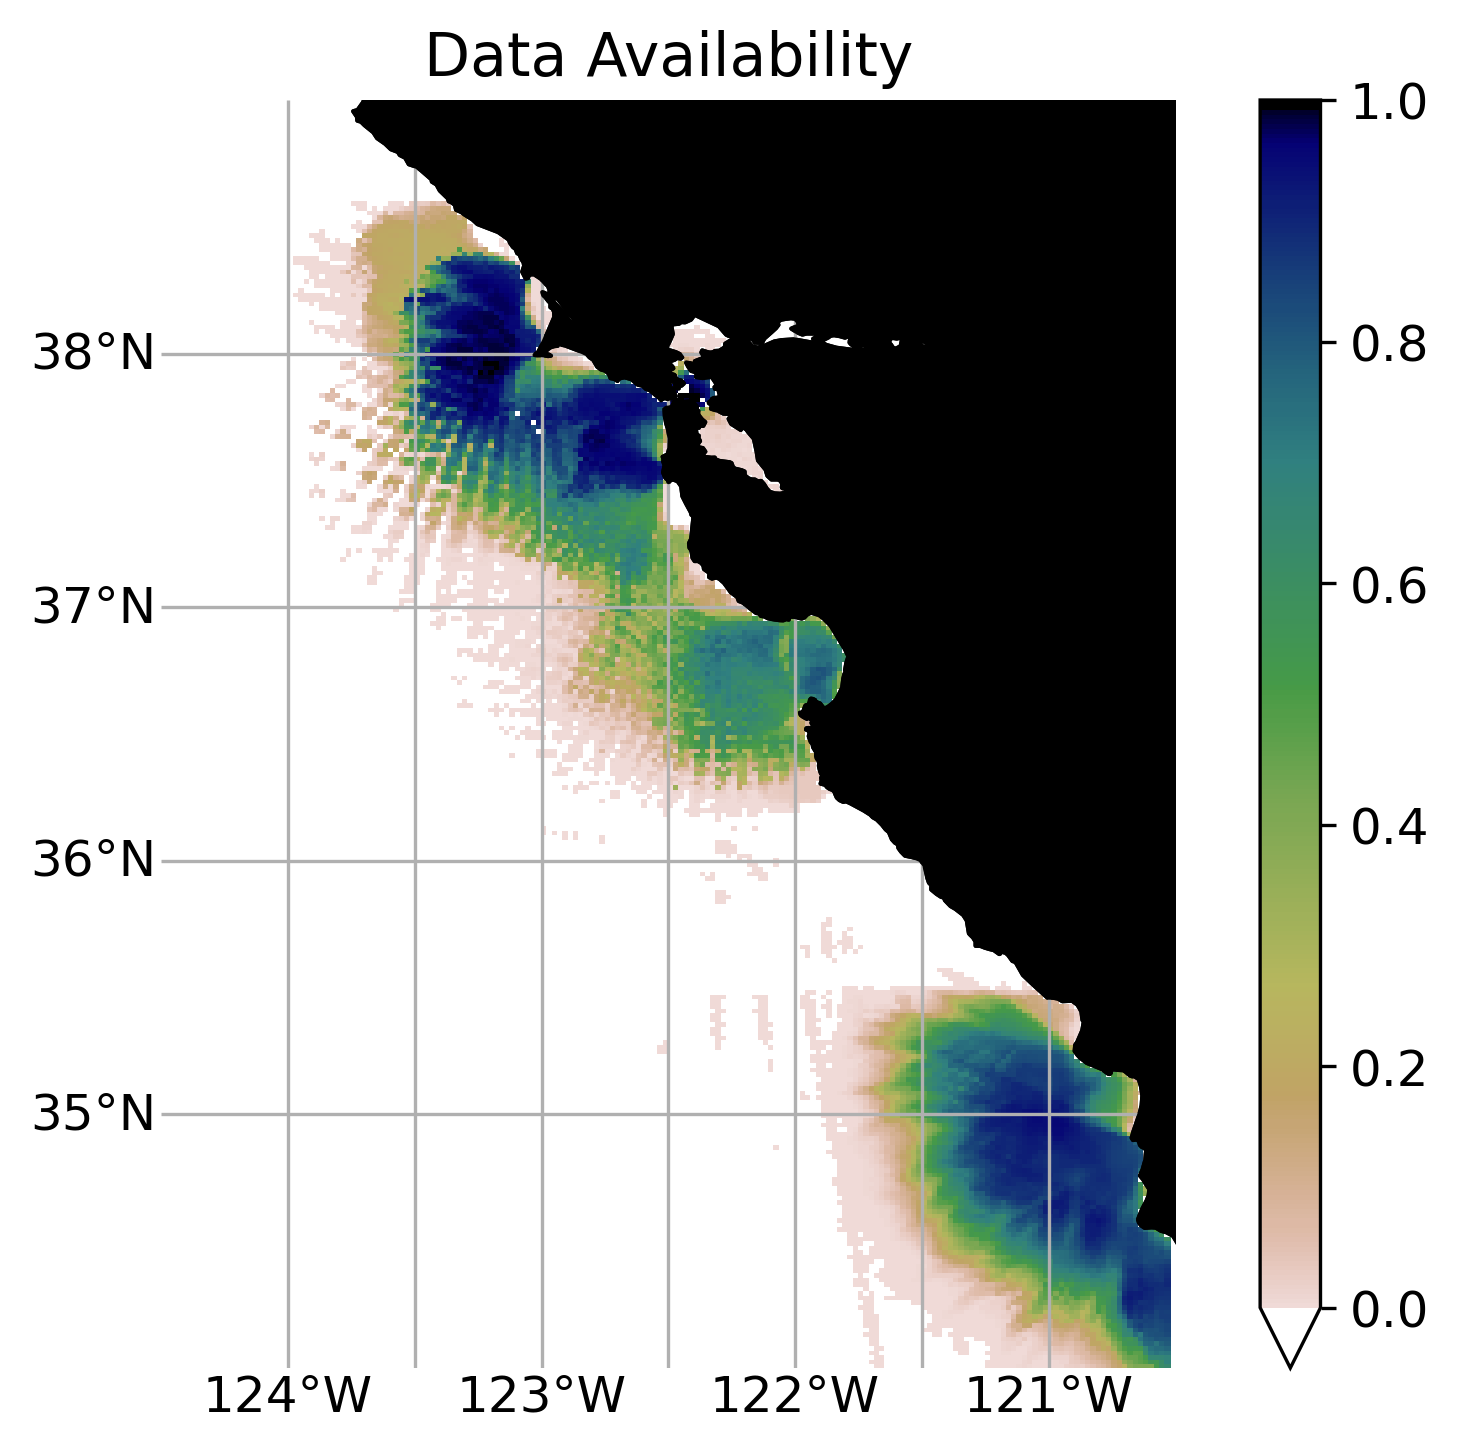

In [154]:
#%% Plot Data Availability
_data_ = ~xr.ufuncs.logical_or(np.isnan( velocity_HF['u']), np.isnan(velocity_HF['v'])) # This way or can short ciruit, returns true if neither is true
u_valid = _data_.mean('time')

fig      = plt.figure(figsize=(6,5),dpi=300, facecolor='white')
ax       = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1);
g        = ax.gridlines(draw_labels=True); g.top_labels = False; g.right_labels=False
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='b',facecolor='black')
ax.add_feature(land_10m, zorder=100, edgecolor='k')

cmap     = copy.copy(plt.cm.get_cmap("gist_earth_r"))
cmap     = personal.plots.truncate_colormap(cmap,.05, 1)
cmap.set_under(color='white')    

u_valid.plot(ax=ax,cmap=cmap,vmin=np.finfo(float).eps,vmax=1,rasterized=True)
# personal.SMODE.draw_SMODE_box(ax)

personal.SMODE.set_ax_SMODE_region(ax)
rc1 = {"font.size" : 12}; plt.rcParams.update(rc1)

plt.box(False) #remove box
cb = ax.collections[-1].colorbar; cb.set_label(''); cb.fontsize=12
plt.title('Data Availability')
fig.canvas.draw()
fig.tight_layout()
fig.savefig('../Figures/S_MODE_data_availability.pdf', bbox_inches='tight')
fig.savefig('../Figures/S_MODE_data_availability.png', bbox_inches='tight')

In [141]:
_data_ = ~xr.ufuncs.logical_or(np.isnan( velocity['u']), np.isnan(velocity['v'])) # This way or can short ciruit, returns true if neither is true
years = np.unique(_data_.time.dt.year)
for year in years:
    print(year)
#     print(_data_.time.dt.year==year)
    u_valid = _data_.isel(time = _data_.time.dt.year==year).mean('time')
    
    fig      = plt.figure(figsize=(6,5),dpi=300, facecolor='white')
    ax       = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', color='black', linewidth=1);
    g        = ax.gridlines(draw_labels=True); g.top_labels = False; g.right_labels=False
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='b',facecolor='black')
    ax.add_feature(land_10m, zorder=100, edgecolor='k')
    cmap     = copy.copy(plt.cm.get_cmap("gist_earth_r"))
    cmap     = personal.plots.truncate_colormap(cmap,.05, 1)
    cmap.set_under(color='white')    

    u_valid.plot(ax=ax,cmap=cmap,vmin=np.finfo(float).eps,vmax=1,rasterized=True)
    # personal.SMODE.draw_SMODE_box(ax)

    personal.SMODE.set_ax_SMODE_region(ax)
    rc1 = {"font.size" : 12}; plt.rcParams.update(rc1)

    plt.box(False) #remove box
    cb = ax.collections[-1].colorbar; cb.set_label(''); cb.fontsize=12
    plt.title('Data Availability | ' + str(year))
    fig.canvas.draw()
    fig.tight_layout()
    fig.savefig('../Figures/S_MODE_data_availability_'+str(year)+'.pdf', bbox_inches='tight')
    fig.savefig('../Figures/S_MODE_data_availability_'+str(year)+'.png', bbox_inches='tight')

    

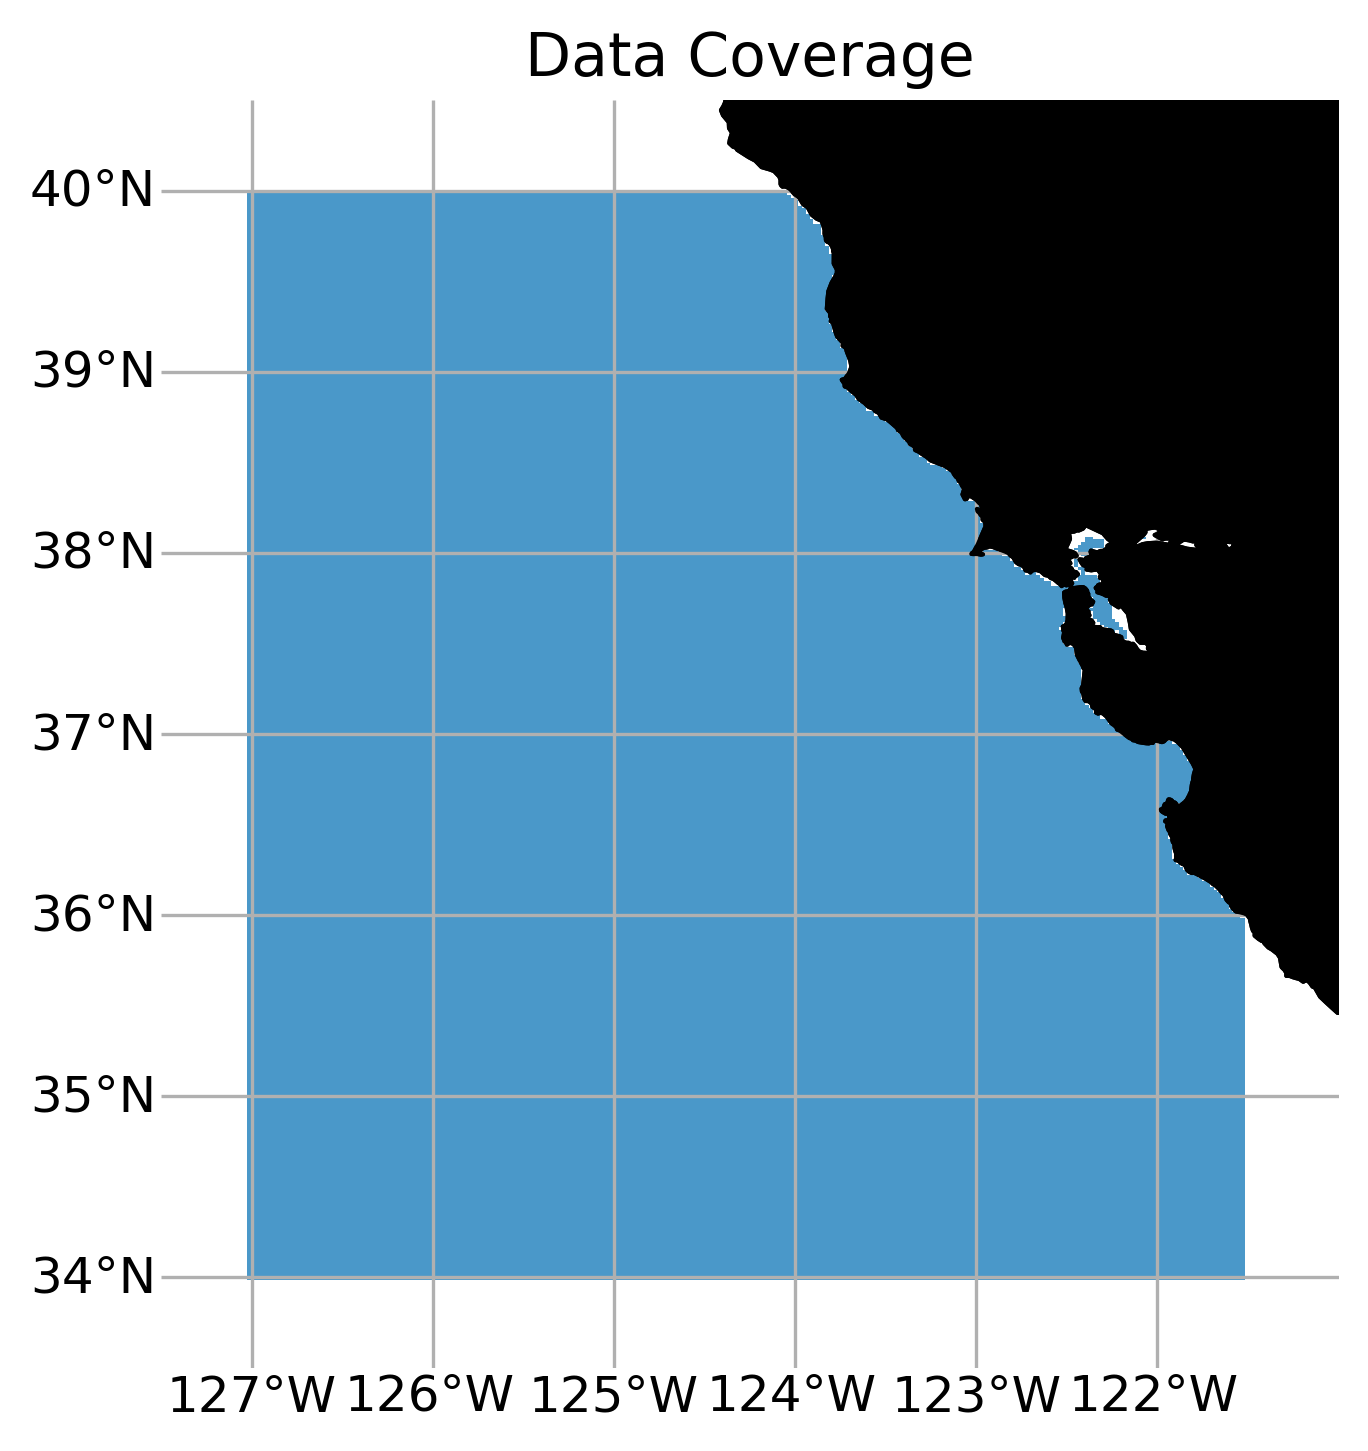

In [172]:
#%% Plot Data Availability
# _data_ = ~xr.ufuncs.logical_or(np.isnan( velocity_LLC['u']), np.isnan(velocity_LLC['v'])) # This way or can short ciruit, returns true if neither is true
# u_valid = _data_.mean('time')
# u_valid = u_valid.compute()

fig      = plt.figure(figsize=(6,5),dpi=300, facecolor='white')
ax       = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1);
g        = ax.gridlines(draw_labels=True); g.top_labels = False; g.right_labels=False
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='b',facecolor='black')
ax.add_feature(land_10m, zorder=100, edgecolor='k')

cmap     = copy.copy(plt.cm.get_cmap("Blues"))
cmap     = personal.plots.truncate_colormap(cmap,.05, .6)
cmap.set_under(color='white')    

u_valid.plot(ax=ax,cmap=cmap,vmin=np.finfo(float).eps,vmax=1,rasterized=True, add_colorbar=True)
# personal.SMODE.draw_SMODE_box(ax)

ax.set_ylim([33.5,40.5])
ax.set_xlim([-127.5, -121])

# personal.SMODE.set_ax_SMODE_region(ax)
rc1 = {"font.size" : 12}; plt.rcParams.update(rc1)

plt.box(False) #remove box
cb = ax.collections[-1].colorbar; cb.set_label(''); cb.fontsize=12
cb.remove()
plt.title('Data Coverage')
fig.canvas.draw()
fig.tight_layout()
fig.savefig('../Figures/LLC4320_data_availability.pdf', bbox_inches='tight')
fig.savefig('../Figures/LLC4320_data_availability.png', bbox_inches='tight')

2012
2013
2014
2015
2016
2017
2018
2019
2020


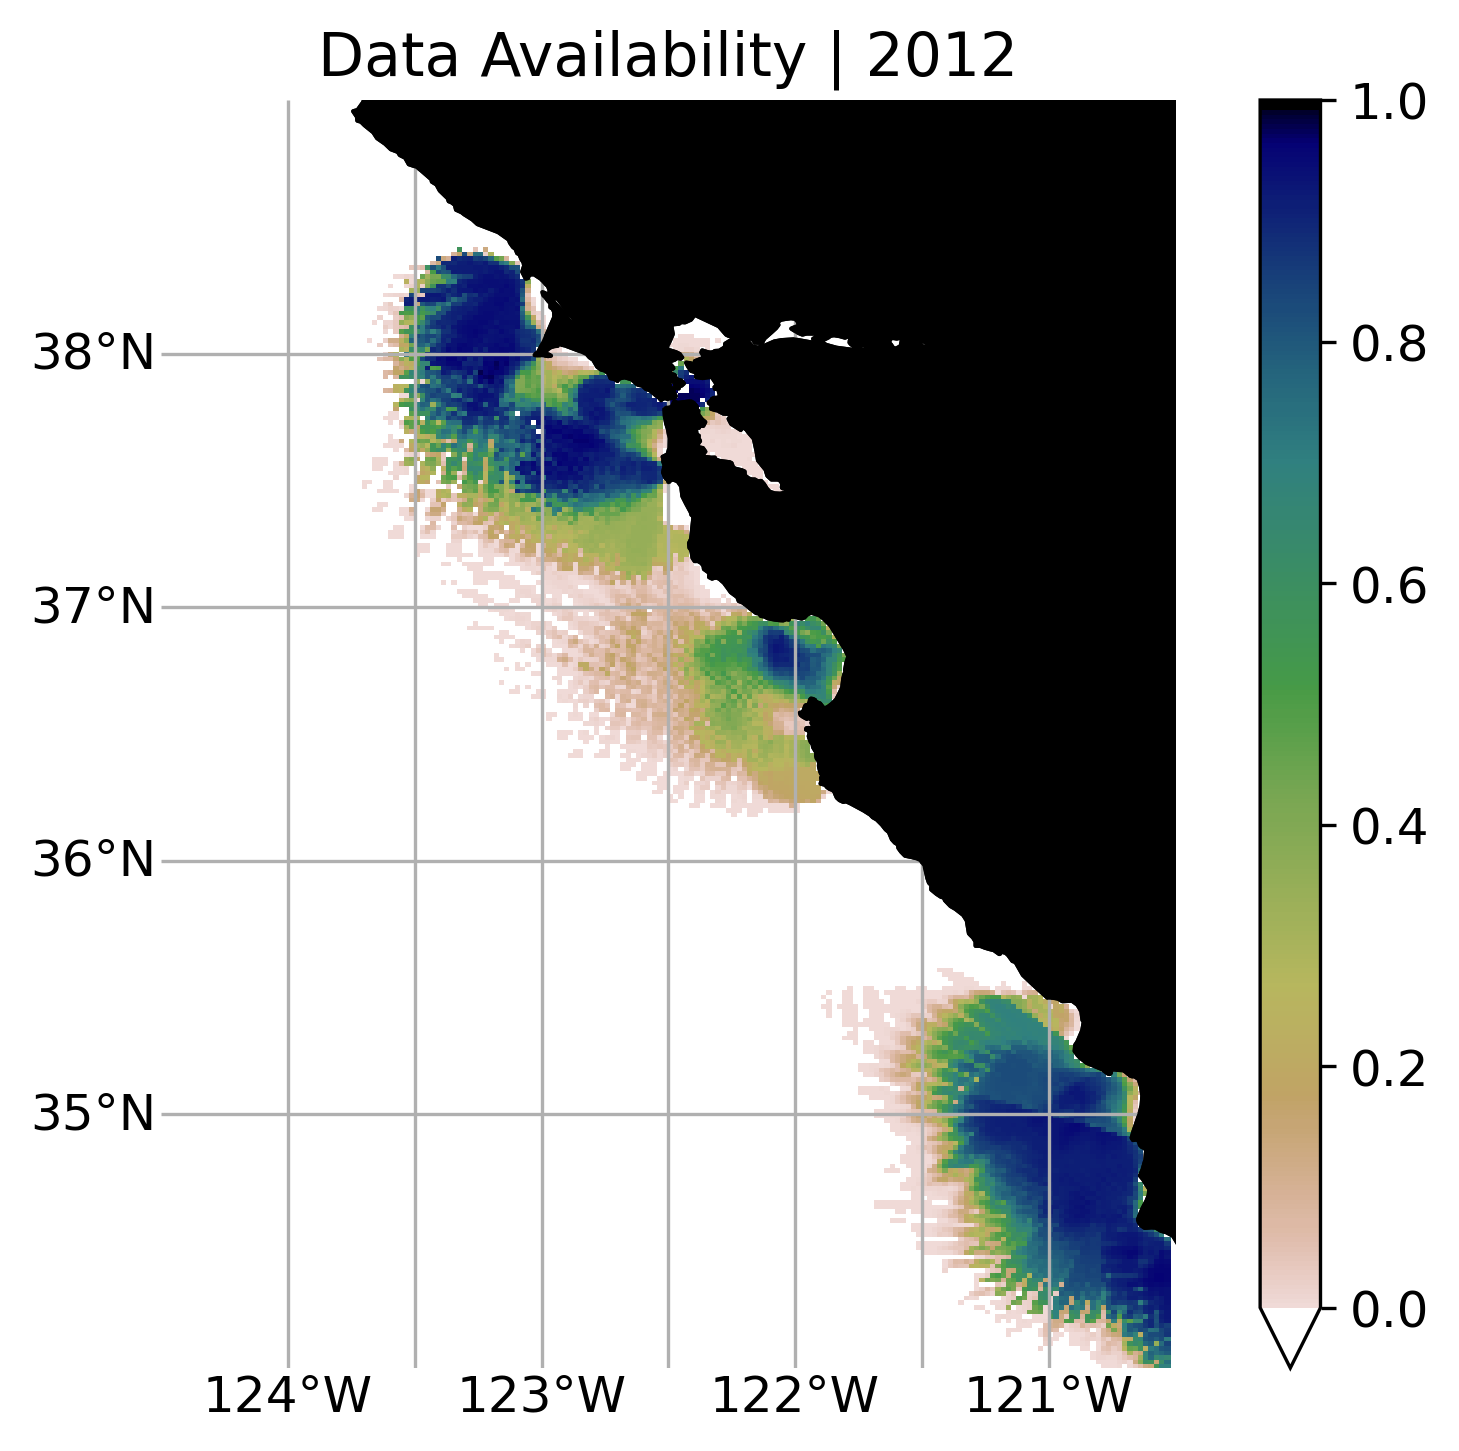

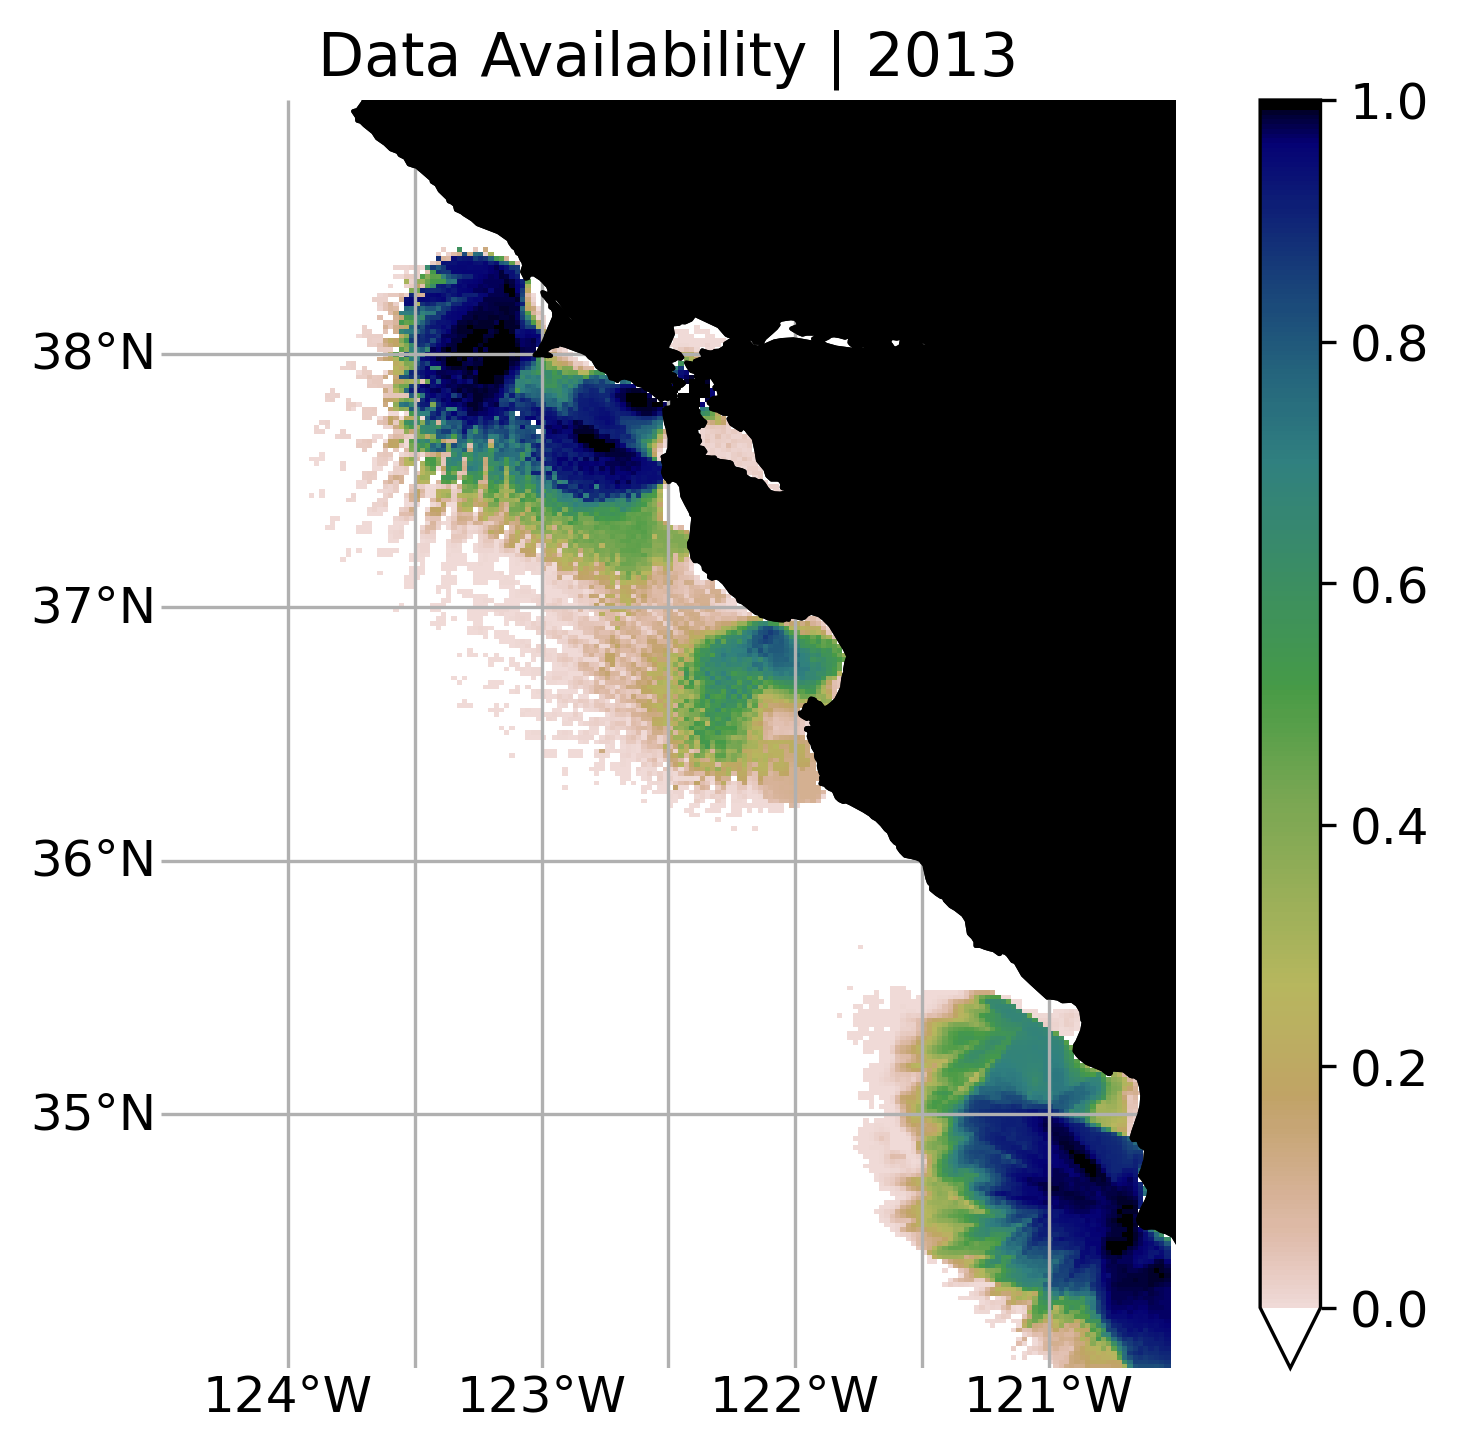

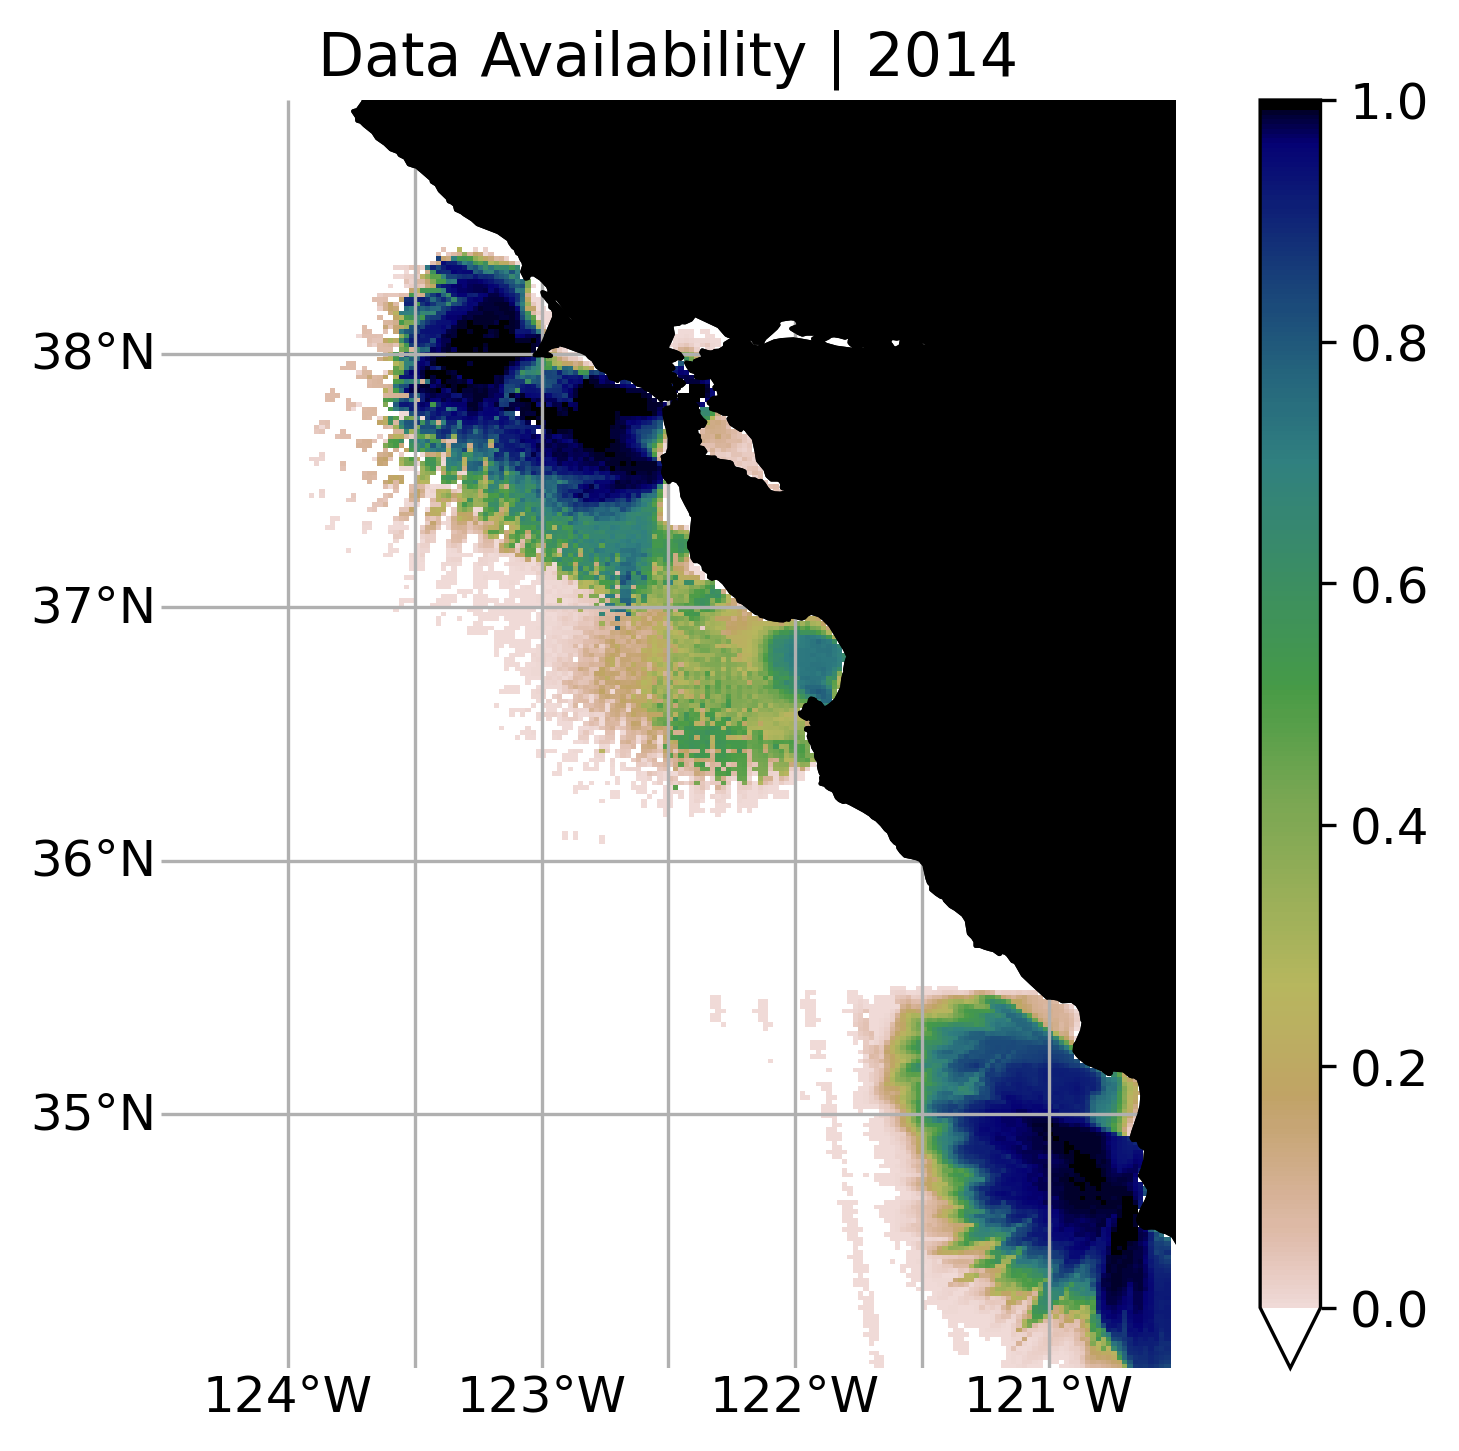

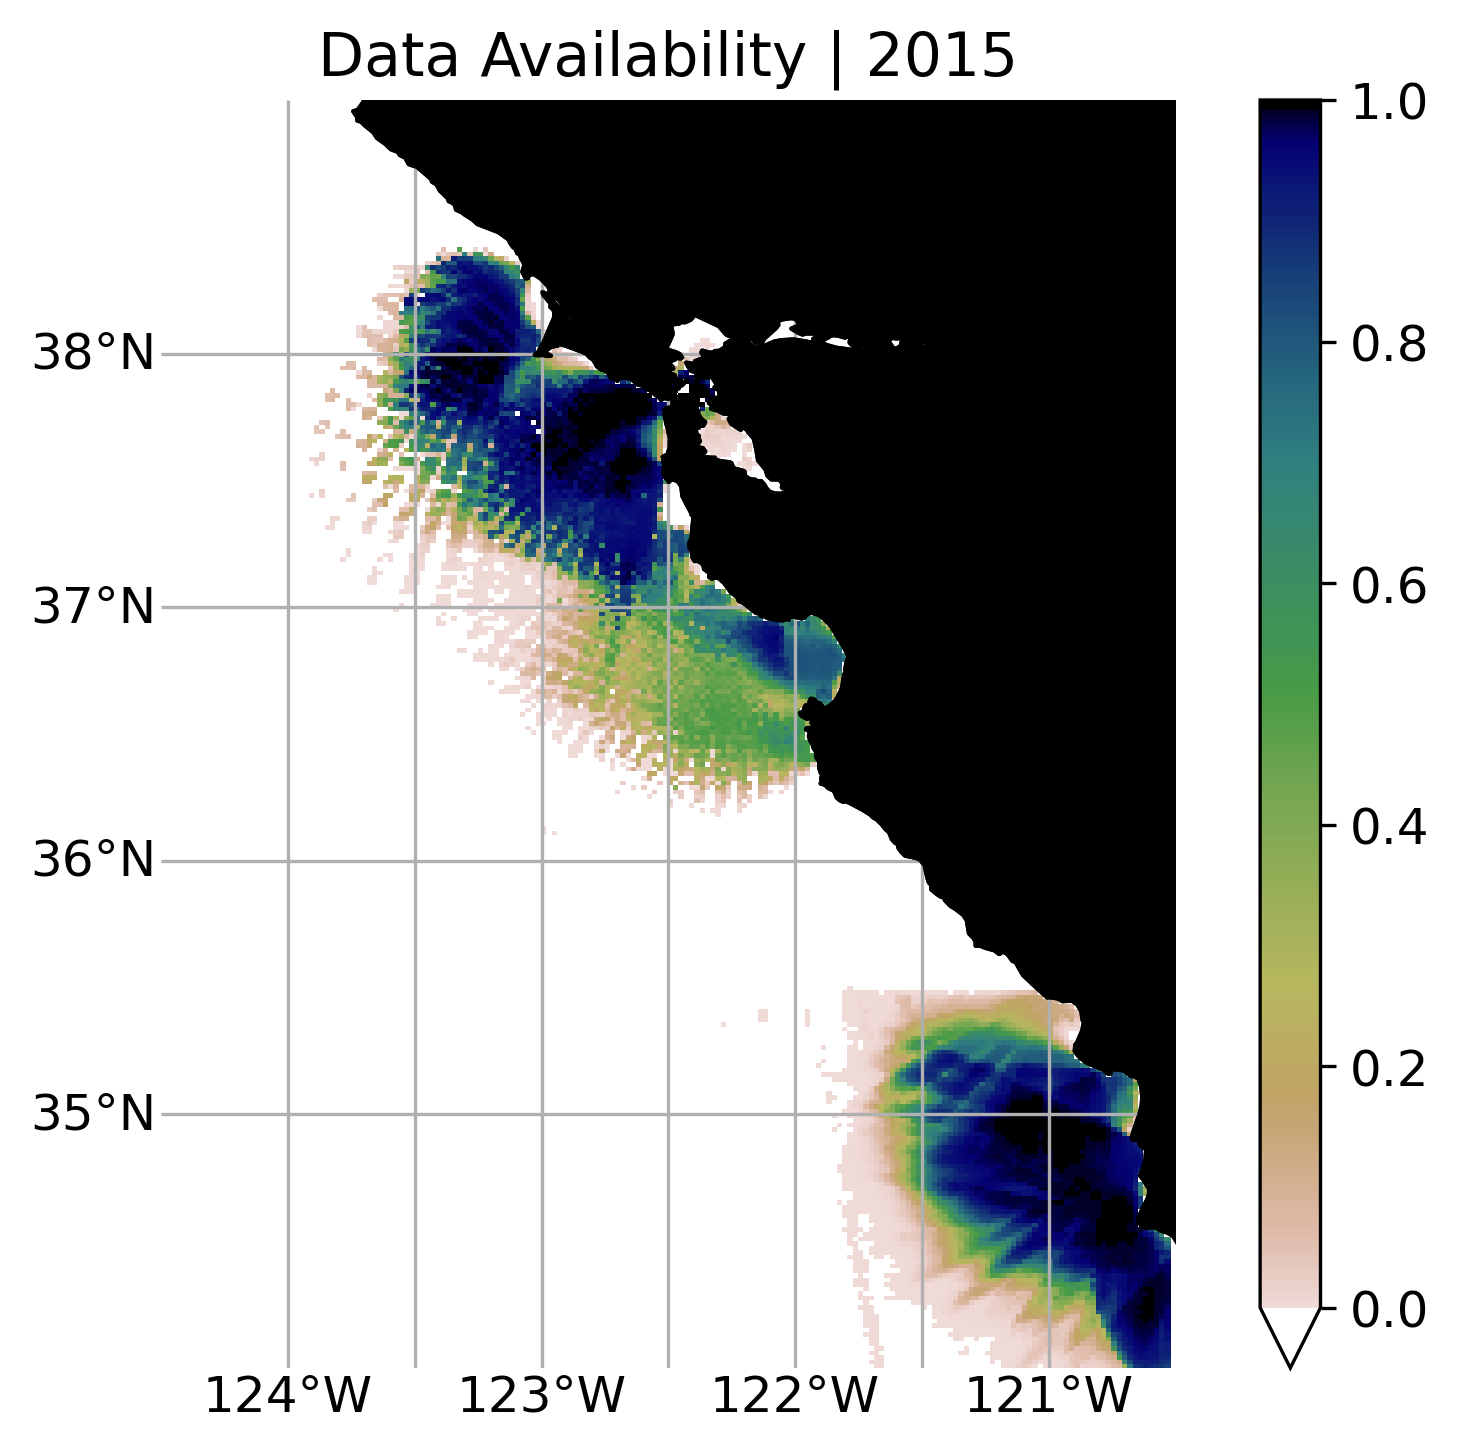

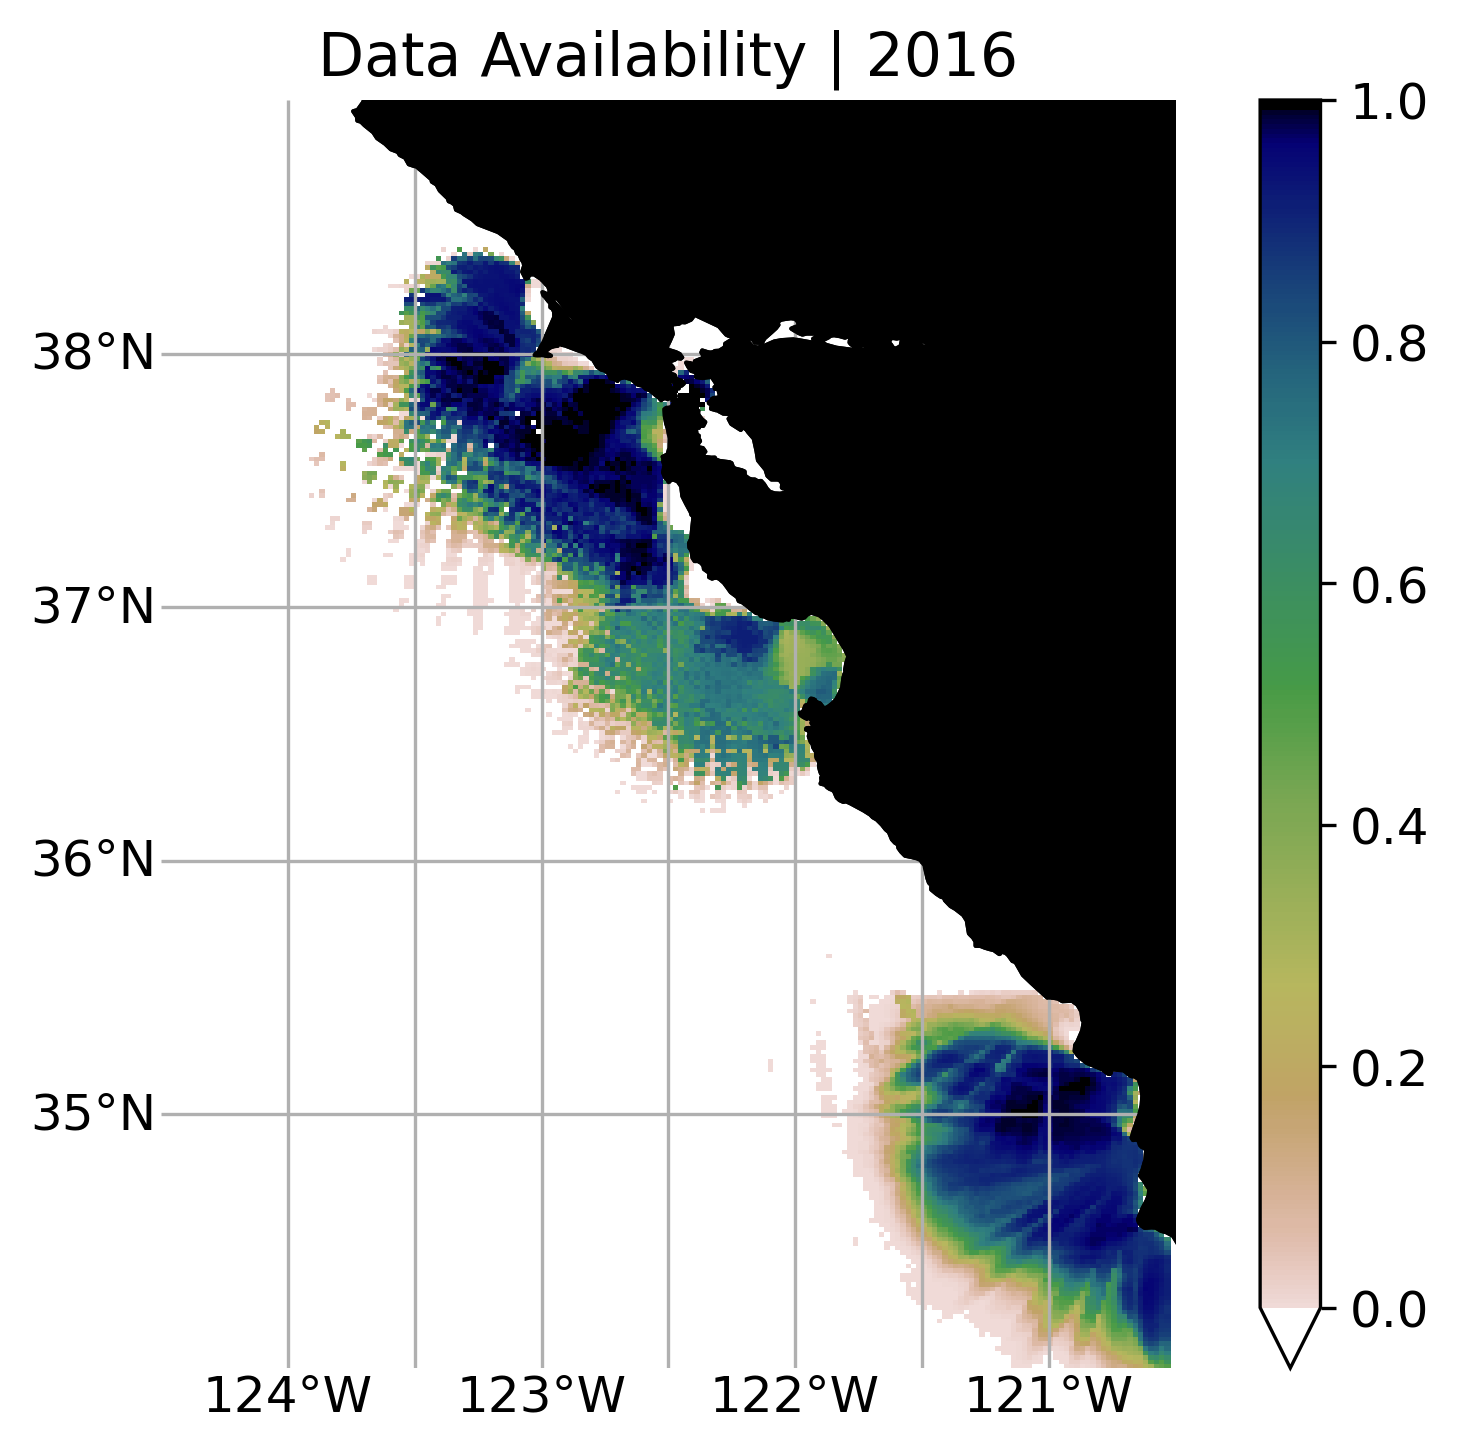

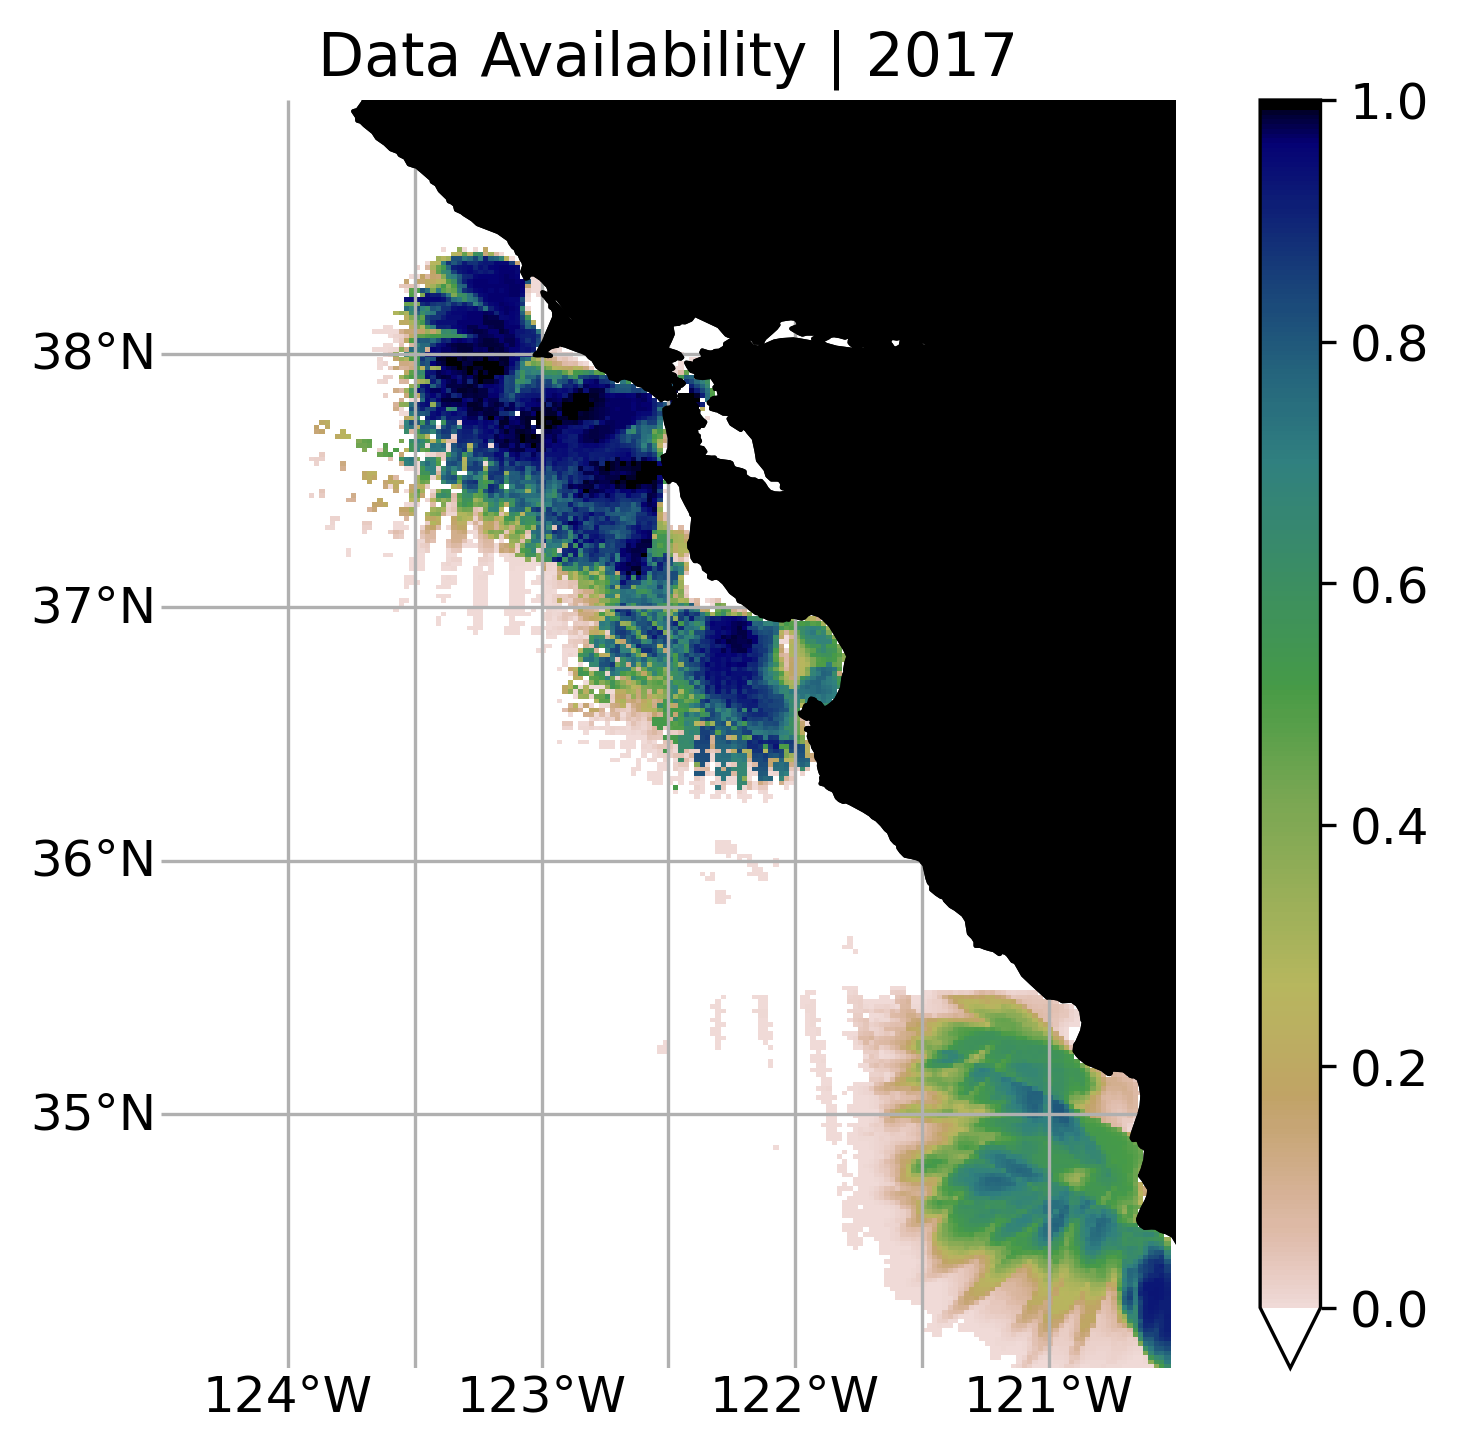

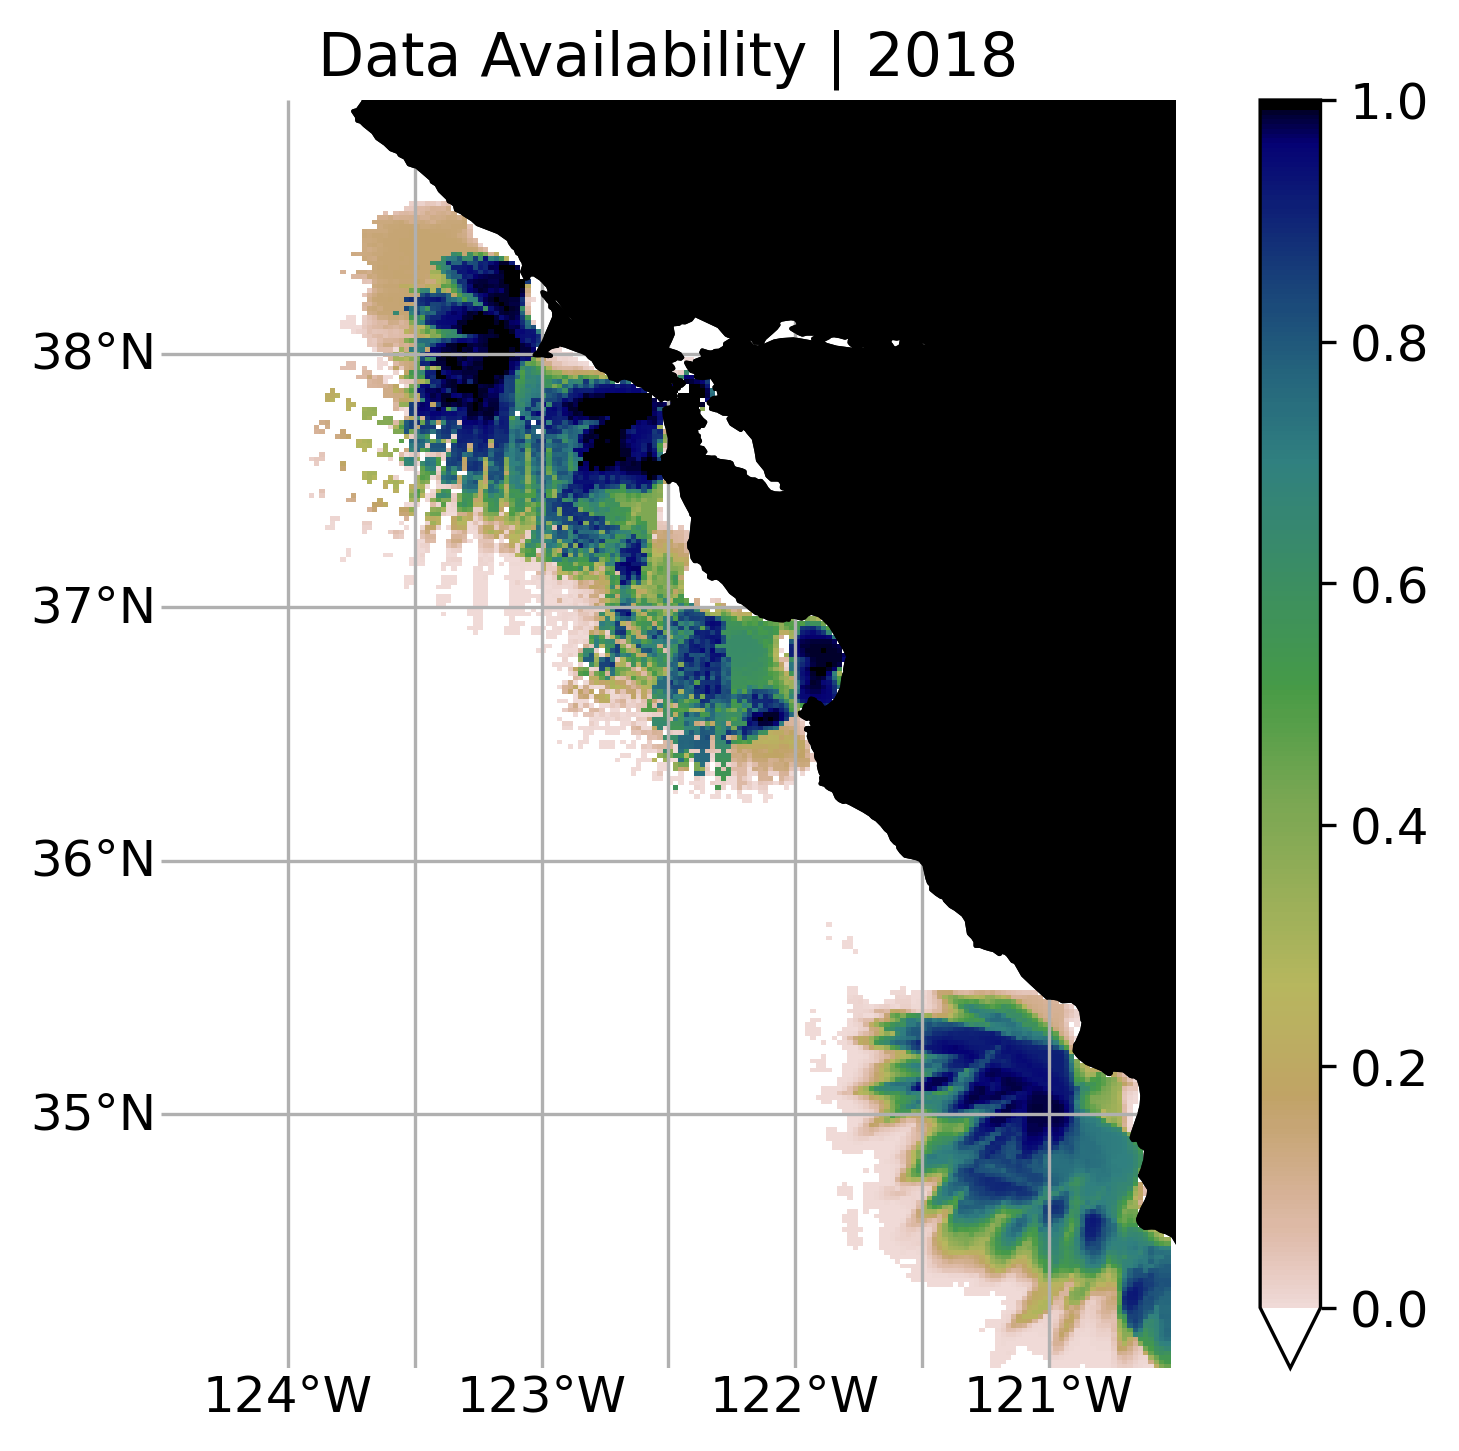

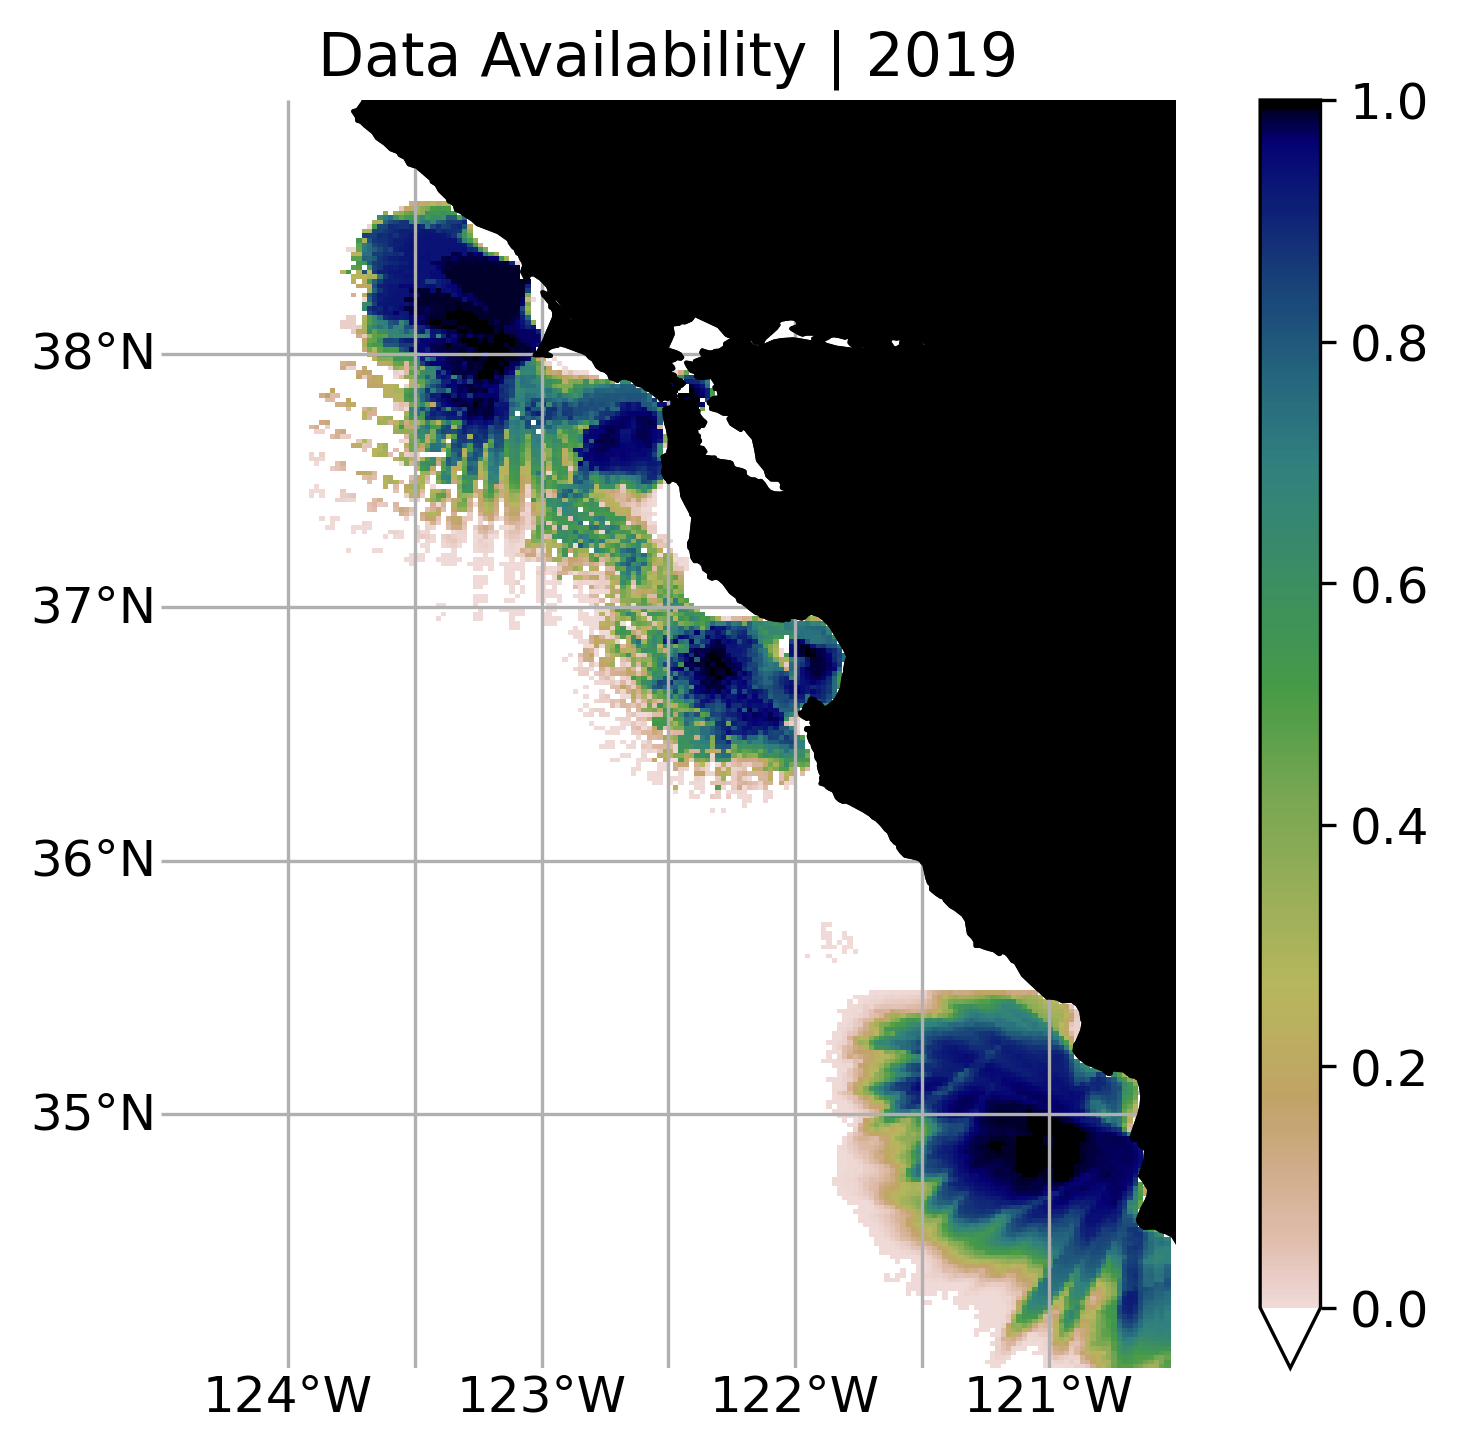

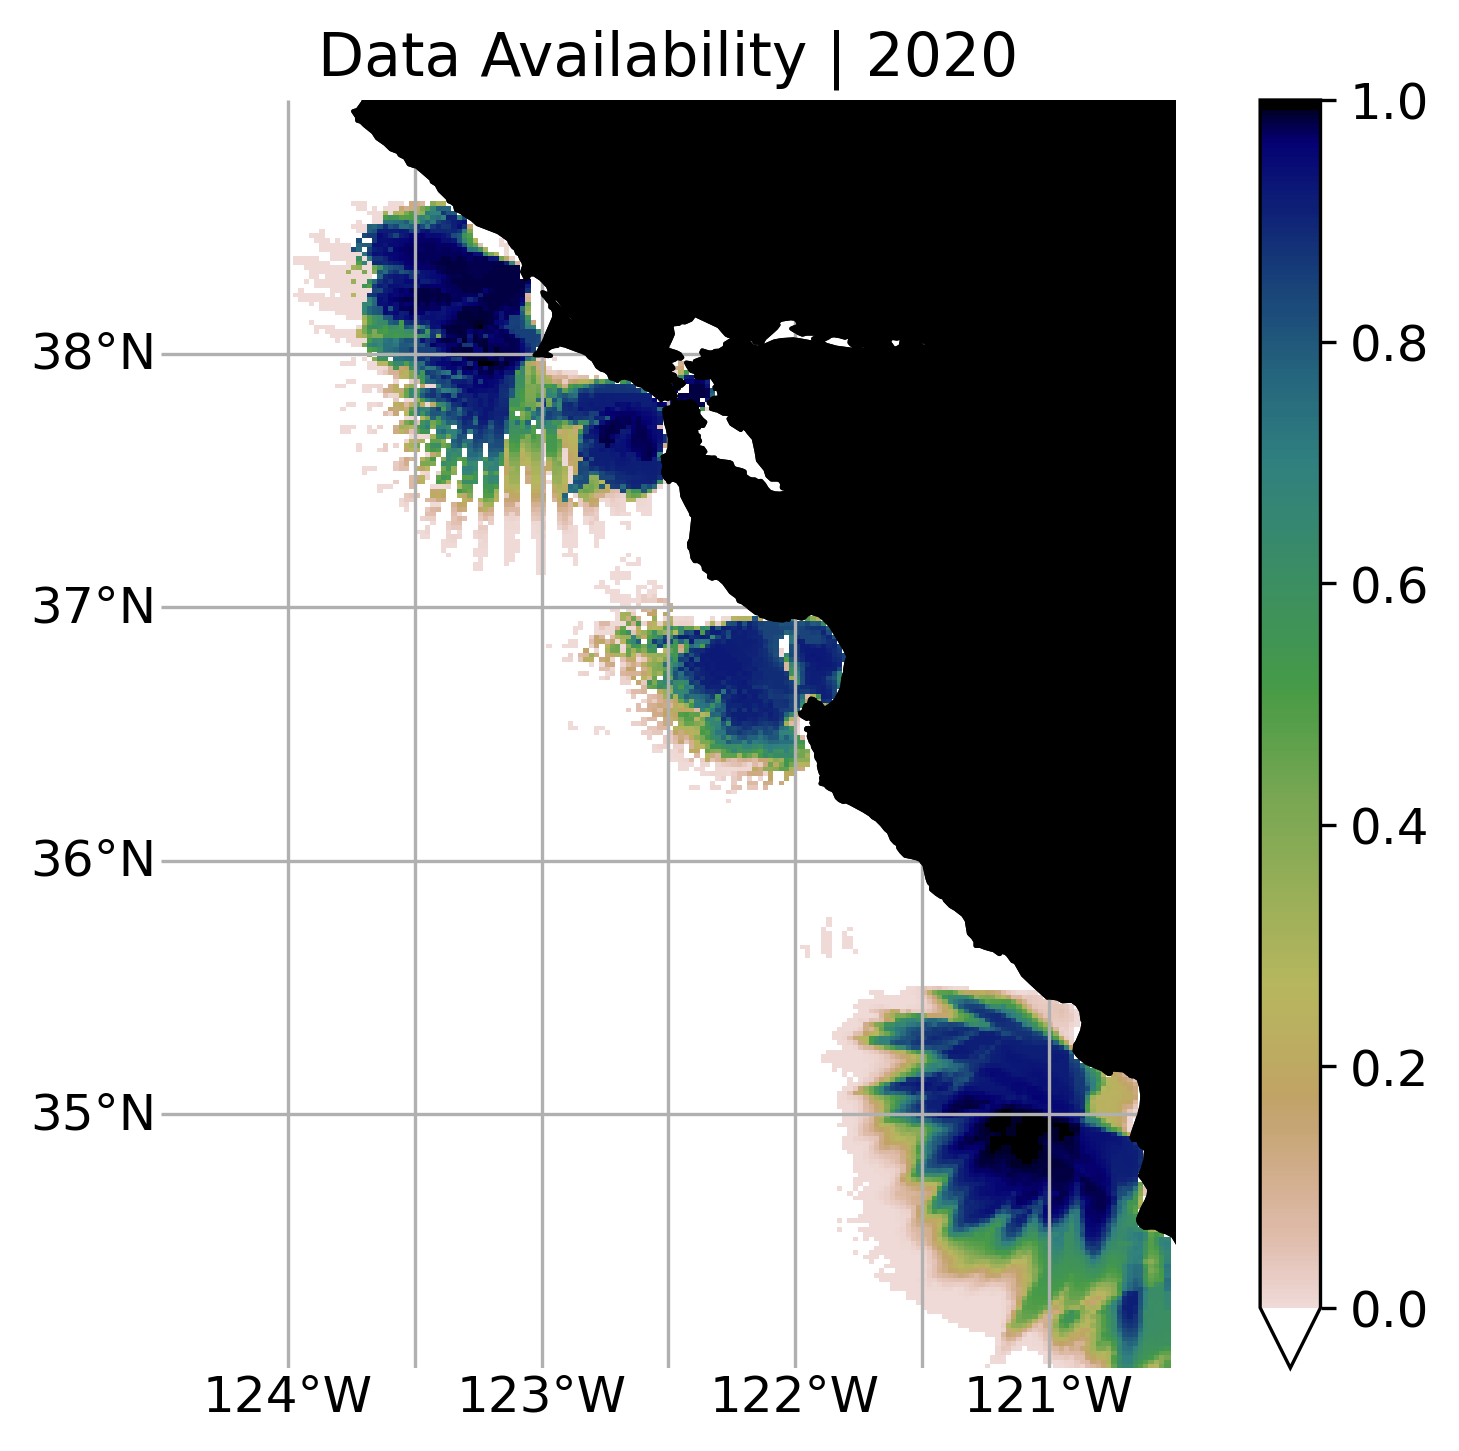

In [ ]:
# try with multiprocessing, ala https://stackoverflow.com/questions/4659680/matplotlib-simultaneous-plotting-in-multiple-threads/4662511#4662511

L = len(smode_data['vorticity'].time)
 

def main():
    pool = multiprocessing.Pool()
    print(pool)
#     input = zip(list(np.arange(L)))
    input = zip(list(np.arange(5)))

    #print(list(input))
    pool.map_async(plot, input)

def plot(i,A=v_new):
    i = i[0]
    print('num is ' + str(i))
    
    fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
    ax = plt.axes(projection=ccrs.PlateCarree(),facecolor='black')
    ax.coastlines(resolution='10m', color='black', linewidth=1);
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='b',facecolor='black')
    ax.background_patch.set_fill(False)
    ax.add_feature(land_10m, zorder=100, edgecolor='k')
    g = ax.gridlines(draw_labels=True)
    g.xlabels_top=False
    g.ylabels_right=False

    personal.SMODE.draw_SMODE_box(ax)
    personal.SMODE.set_ax_SMODE_region(ax)
    plt.rcParams.update({'font.size': 12})
    plt.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=0.99)
    scaling = 10**4

    import matplotlib.colors
    from matplotlib import cm
    cax = (scaling * A[i]).plot(ax=ax,cmap=cm.get_cmap('RdBu', 2**6+1),vmin=2,vmax=-2)

    cax.cmap.set_bad(color=[.8,.8,.8])
    ax.set_title('HF Radar 2km vorticity, ' + str(A[i].time.dt.strftime('%m-%d-%Y %H:%M').values))
    time = A[i].time.dt.strftime('%m-%d-%Y_%H:%M').values
    print(time)
    fig.savefig('../Figures/Vorticity_Test/S_MODE_data_availability_' + str(i) + '.png')
    plt.close(fig)

    return i

main()

In [ ]:
plt.get_fignums()
print('hi')

In [ ]:
# pure dask, gets hung up on loading data or plotting... if follows neither does xarray
inds = np.arange(len(smode_data['vorticity'].time))
@da.as_gufunc(signature="()->()", output_dtypes=type(np.random.rand(3,4)), vectorize=True) #using a decorator!, see https://docs.dask.org/en/latest/array-api.html#generalized-ufuncs
def f(i,A=v_new):
    fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
    ax = plt.axes(projection=ccrs.PlateCarree(),facecolor='black')
    ax.coastlines(resolution='10m', color='black', linewidth=1);
    land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='b',facecolor='black')
    ax.background_patch.set_fill(False)
    ax.add_feature(land_10m, zorder=100, edgecolor='k')
    g =  ax.gridlines(draw_labels=True)
    g.xlabels_top=False
    g.ylabels_right=False

    personal.SMODE.draw_SMODE_box(ax)
    personal.SMODE.set_ax_SMODE_region(ax)
    plt.rcParams.update({'font.size': 12})
    plt.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=0.99)
    scaling = 10**4

    import matplotlib.colors
    from matplotlib import cm
    print((A[i] * scaling).values)
#     cax = (scaling * A[i]).plot(ax=ax,cmap=cm.get_cmap('RdBu', 2**6+1),vmin=2,vmax=-2)

#     cax.cmap.set_bad(color=[.8,.8,.8])
    time = A[i].time.dt.strftime('%m-%d-%Y_%H:%M').values
    print(time)
    fig.savefig('../Figures/Vorticity_Test/S_MODE_data_availability.png')
    return(i)

f(inds[0])
# f(inds[1])

In [ ]:
figs_out[0].compute()

In [ ]:
print(smode_data['vorticity'])


In [ ]:
Jac = xr.apply_ufunc(
    F,
    smode_data_mp['u'],
    smode_data_mp['v'],
    input_core_dims = [["lat","lon"],["lat","lon"]],    # dims we mut have
    output_core_dims = [["lat","lon",'deriv']],         # dims output must have
    exclude_dims = set(()),                             # dims to exclude from broadcasting and alignment
    vectorize = True,                                   # 
    keep_attrs = False,
    dask = "parallelized",                              # ’forbidden’ (default): raise an error if a dask array is encountered. ’allowed’: pass dask arrays directly on to func. ’parallelized’: automatically parallelize func if any of the inputs are a dask array. If used, the output_dtypes argument must also be provided. Multiple output arguments are not yet supported.
    output_dtypes=[smode_data_mp['u'].dtype],
    output_sizes={'deriv':4}
    )
Jac['deriv'] = new_coords['deriv']

In [ ]:
# could try to recreate w/ stats and skew_pdf but for now will just do natively (would be better than groupby for time avgs?) ...

# data = xr.open_mfdataset(data_source+'/analysis/stats_fulltime.nc', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override")

file_path_new    = os.path.abspath(os.path.dirname(''))
data_relpath_new = "../Data/HF_Radar/2km/processed/smode_region/"
data_source_new  = os.path.normpath(os.path.join(file_path_new, data_relpath_new))
time_chunk = 24
vor = xr.open_mfdataset(data_source_new+'/vorticity/*.nc', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override").chunk({'time':time_chunk})
# vor = personal.SMODE.select_SMODE_region(vor,rechunk=True,time_chunk=time_chunk) #.metpy.parse_cf() don't parse here (only for mpcalc) bc can't save parsed?

In [94]:
h_smoothed,_ = da.histogram(data_smoothed.data*scaling,bins=bins,density=True)
h_smoothed
h_smoothed = h.compute()

In [95]:
data = vor['vorticity']# select our data (could also do like groupby seasonal means etc?)
# data_day = data.resample(time="1D").mean()
data_month = data.resample(time="1M").mean().load() # just go ahead now and load, should be small and fast

data = data_month

In [ ]:
data = xr.open_mfdataset(data_source+'/gradients/*.nc', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override").chunk({'time':time_chunk,'deriv':1})

# deriv = 'dudx' 'dudy' 'dvdx' 'dvdy'
data['vorticity' ]         = data['gradients'][:,:,:,2] - data['gradients'][:,:,:,1] # dv/dx - du/dy
# smode_data['divergence']         = smode_data['gradients'][:,:,:,0] + smode_data['gradients'][:,:,:,3] # du/dx + dv/dy
# smode_data['shear_strain_rate']  = smode_data['gradients'][:,:,:,2] + smode_data['gradients'][:,:,:,1] # dv/dx + du/dy
# smode_data['normal_strain_rate'] = smode_data['gradients'][:,:,:,0] - smode_data['gradients'][:,:,:,3] # du/dx - dv/dy
# smode_data['strain_rate']        = (smode_data['normal_strain_rate']**2 + smode_data['shear_strain_rate']**2)**(1./2)
# smode_data['speed']              = (velocity['u']**2  + velocity['v']**2)**(1./2)

data = data.drop('gradients')

In [761]:
data_smoothed = xr.open_mfdataset(data_source+'/gradients/smoothed/*.nc', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override").chunk({'time':time_chunk,'deriv':1})

# deriv = 'dudx' 'dudy' 'dvdx' 'dvdy'
data_smoothed['vorticity' ]         = data_smoothed['gradients'][:,:,:,2] - data_smoothed['gradients'][:,:,:,1] # dv/dx - du/dy
# smode_data['divergence']         = smode_data['gradients'][:,:,:,0] + smode_data['gradients'][:,:,:,3] # du/dx + dv/dy
# smode_data['shear_strain_rate']  = smode_data['gradients'][:,:,:,2] + smode_data['gradients'][:,:,:,1] # dv/dx + du/dy
# smode_data['normal_strain_rate'] = smode_data['gradients'][:,:,:,0] - smode_data['gradients'][:,:,:,3] # du/dx - dv/dy
# smode_data['strain_rate']        = (smode_data['normal_strain_rate']**2 + smode_data['shear_strain_rate']**2)**(1./2)
# smode_data['speed']              = (velocity['u']**2  + velocity['v']**2)**(1./2)

data_smoothed = data_smoothed.drop('gradients')

In [762]:
data_smoothed

,Array,Chunk
Bytes,588.95 kB,192 B
Shape,"(73619,)","(24,)"
Count,17188 Tasks,3068 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,19.65 GB,6.41 MB
Shape,"(73619, 278, 240)","(24, 278, 240)"
Count,52788 Tasks,3068 Chunks
Type,float32,numpy.ndarray


[0, 5, 10, 16, 21, 26, 32, 37, 42, 48, 53, 59, 64, 69, 75, 80, 85, 91, 96, 102]
5


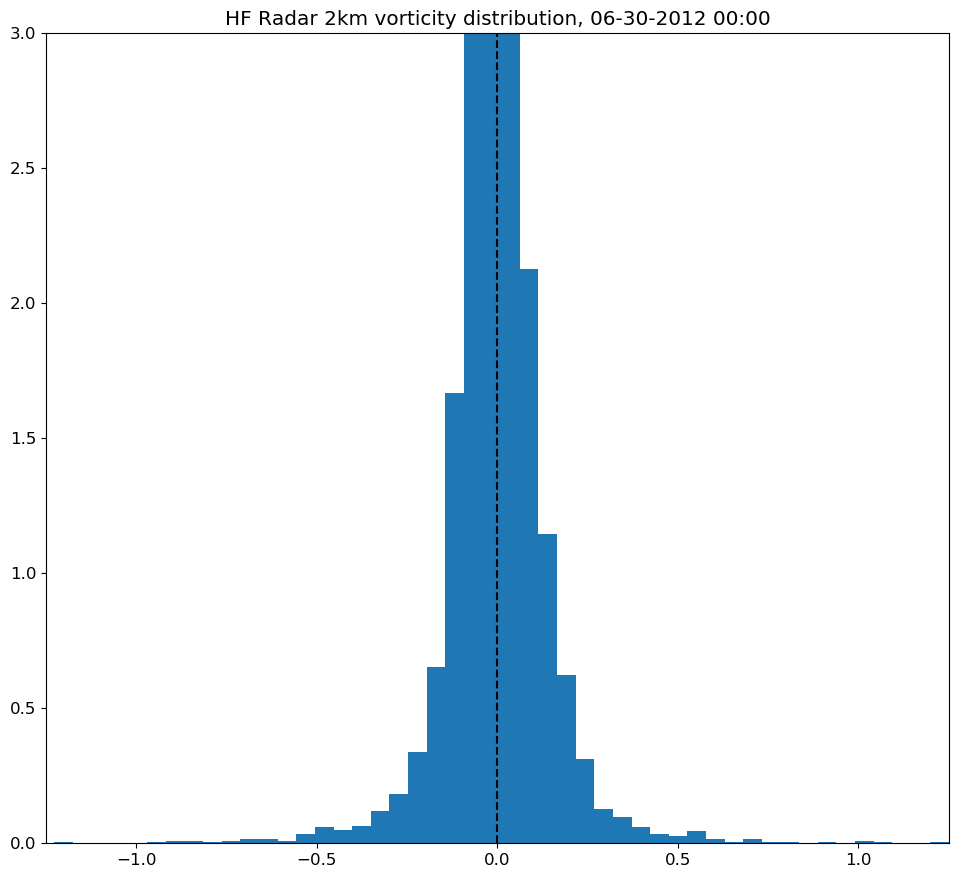

<module 'ffmpeg' from '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ffmpeg/__init__.py'>
5
5
10
16
21
26
32
37
42
48
53
59
64
69
75
80
85
91
96
102


In [106]:
#%% Plot Vorticity Histogram Animation (we should make a fcn to automate these types of plots w/ ust the plotting fcn needed?)
import matplotlib.colors
from matplotlib import cm
import personal.date_operations as pdo


fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
ax = plt.axes(facecolor=None)
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=0.99)
scaling = 10**4

d = np.ravel(data[0]) * scaling
d = d[~np.isnan(d)]
counts, bins = np.histogram(d,bins=150,density=True) # fails on [nan nan] range for some reason...

ax.hist(d,bins=bins,density=True)
ax.axvline(0, color='k', linestyle='--')
ax.set_ylim([0,3])
ax.set_xlim([-1.25,1.25])

L = len(data.time)
num_frames = 20
indices = [int(x) for x in np.linspace(0,len(data.time)-1,num=num_frames)]
print(indices)
title = ax.set_title('HF Radar 2km vorticity distribution, ' + str(data[0].time.dt.strftime('%m-%d-%Y %H:%M').values))

interval=100 # ms
def animate(i,data=data,num=num_frames,repeat_delay=1000):
    print(i)
    ax.clear()
    d = np.ravel(data[i]) * scaling
    d = d[~np.isnan(d)]
    ax.hist(d,bins=bins,density=True)
    ax.axvline(0, color='k', linestyle='--')
    ax.set_ylim([0,3])
    ax.set_xlim([-1.25,1.25])
    ax.set_title('HF Radar 2km vorticity distribution, ' + str(data[i].time.dt.strftime('%m-%d-%Y %H:%M').values))
    return
anim = FuncAnimation(fig, animate, interval=interval, frames=indices[1:])
plt.draw()
plt.show()

import ffmpeg
print(ffmpeg)
plt.rcParams['animation.ffmpeg_path']='‪/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ffmpeg/'
# plt.rcParams['animation.ffmpeg_path']='/export/home1/jbenjami/anaconda3/bin/ffmpeg'
# my_ffmpeg_writer = animation.FFMpegWriter(fps=1000//interval, codec='libx264', extra_args=[])
my_ffmpeg_writer = animation.PillowWriter()  


anim.save('../Figures/vorticity_hist_monthly.png',writer=my_ffmpeg_writer)


In [620]:
data = vor['vorticity']
nbins = 150
L = len(data['time'])
dmin = da.nanmin(data.chunk({'time':1000}).data).compute() * scaling
dmax = da.nanmax(data.chunk({'time':1000}).data).compute() * scaling
bins  = np.linspace(dmin,dmax,num=nbins+1)
# _, bins =  np.histogram(np.ravel(data)*scaling,bins=bins,density=True)  #.compute()

In [625]:
nbins = 300
bins  = np.linspace(dmin,dmax,num=nbins+1)
bins

array([-9.08346497, -9.02274339, -8.9620218 , -8.90130021, -8.84057862,
       -8.77985704, -8.71913545, -8.65841386, -8.59769227, -8.53697069,
       -8.4762491 , -8.41552751, -8.35480592, -8.29408433, -8.23336275,
       -8.17264116, -8.11191957, -8.05119798, -7.9904764 , -7.92975481,
       -7.86903322, -7.80831163, -7.74759005, -7.68686846, -7.62614687,
       -7.56542528, -7.50470369, -7.44398211, -7.38326052, -7.32253893,
       -7.26181734, -7.20109576, -7.14037417, -7.07965258, -7.01893099,
       -6.95820941, -6.89748782, -6.83676623, -6.77604464, -6.71532305,
       -6.65460147, -6.59387988, -6.53315829, -6.4724367 , -6.41171512,
       -6.35099353, -6.29027194, -6.22955035, -6.16882876, -6.10810718,
       -6.04738559, -5.986664  , -5.92594241, -5.86522083, -5.80449924,
       -5.74377765, -5.68305606, -5.62233448, -5.56161289, -5.5008913 ,
       -5.44016971, -5.37944812, -5.31872654, -5.25800495, -5.19728336,
       -5.13656177, -5.07584019, -5.0151186 , -4.95439701, -4.89

In [621]:
len(bins)

151

In [619]:
bins

array([-9.08346497e-04, -8.96202180e-04, -8.84057862e-04, -8.71913545e-04,
       -8.59769227e-04, -8.47624910e-04, -8.35480592e-04, -8.23336275e-04,
       -8.11191957e-04, -7.99047640e-04, -7.86903322e-04, -7.74759005e-04,
       -7.62614687e-04, -7.50470369e-04, -7.38326052e-04, -7.26181734e-04,
       -7.14037417e-04, -7.01893099e-04, -6.89748782e-04, -6.77604464e-04,
       -6.65460147e-04, -6.53315829e-04, -6.41171512e-04, -6.29027194e-04,
       -6.16882876e-04, -6.04738559e-04, -5.92594241e-04, -5.80449924e-04,
       -5.68305606e-04, -5.56161289e-04, -5.44016971e-04, -5.31872654e-04,
       -5.19728336e-04, -5.07584019e-04, -4.95439701e-04, -4.83295384e-04,
       -4.71151066e-04, -4.59006748e-04, -4.46862431e-04, -4.34718113e-04,
       -4.22573796e-04, -4.10429478e-04, -3.98285161e-04, -3.86140843e-04,
       -3.73996526e-04, -3.61852208e-04, -3.49707891e-04, -3.37563573e-04,
       -3.25419256e-04, -3.13274938e-04, -3.01130620e-04, -2.88986303e-04,
       -2.76841985e-04, -

In [591]:
d = np.ravel(data[0]) * scaling
d = d[~np.isnan(d)]
# counts, bins = np.histogram(data[~np.isnan(data)],bins=150,density=True) # fails on [nan nan] range for some reason...

data = data.chunk({'time':1000}).rolling({'time':24*30},center=True,min_periods=1)
data = data.construct('time_groups').chunk({'time':1})
data = data.assign_coords({'time_groups':data.time_groups.values})
print(data)

IndexError: 3-dimensional boolean indexing is not supported. 

In [434]:
# If you wanna preallocate out to speed up plotting later...
out = np.empty([len(gg),len(counts)])
for i,v in enumerate(gg):
    print(i)
    out[i],_ = np.histogram(np.ravel(v)*scaling,bins=bins,density=True)

new_coords = {'time':gg.time, 'bin':list(range(len(counts)))}
new_dims   = new_coords.keys()

out = xr.DataArray(out,coords=new_coords,dims=new_dims)


In [ ]:
fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
ax = plt.axes(facecolor=None)
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=0.99)
scaling = 10**4


# ax.hist(d,bins=bins,density=True)
ax.axvline(0, color='k', linestyle='--')
ax.set_ylim([0,3])
ax.set_xlim([-1.25,1.25])

L = len(data.time)
print(L)
num_frames = 100
indices = [int(x) for x in np.linspace(0,len(data.time)-1,num=num_frames)]
print(indices)
title = ax.set_title('HF Radar 2km vorticity distribution, ' + str(data[0].time.dt.strftime('%m-%d-%Y %H:%M').values))

interval=500 # ms
def animate(i,data=data,num=num_frames,repeat_delay=1000):
    print(i)
    ax.clear()
    

    out,_ = np.histogram(np.ravel(data[i])*scaling,bins=bins,density=True)
    ax.hist(bins[:-1], bins, weights=out)
#     ax.hist(d,bins=bins,density=True)
    ax.axvline(0, color='k', linestyle='--')
    ax.set_ylim([0,3])
    ax.set_xlim([-1.25,1.25])
    ax.set_title('HF Radar 2km vorticity distribution, ' + str(data[i].time.dt.strftime('%m-%d-%Y %H:%M').values))
    return
anim = FuncAnimation(fig, animate, interval=interval, frames=indices[:])
plt.draw()
plt.show()

In [ ]:
save_interval = 100
import ffmpeg
print(ffmpeg)
plt.rcParams['animation.ffmpeg_path']='‪/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/ffmpeg/'
# plt.rcParams['animation.ffmpeg_path']='/export/home1/jbenjami/anaconda3/bin/ffmpeg'
# my_ffmpeg_writer = animation.FFMpegWriter(fps=1000//interval, codec='libx264', extra_args=[])
my_ffmpeg_writer = animation.PillowWriter(fps=1000//save_interval)  

# separate the calculate from the plot steps

anim.save('../Figures/vor_hist_bin_test.png',writer=my_ffmpeg_writer)

In [ ]:
nbins = 600
bins  = np.linspace(dmin,dmax,num=nbins+1)

data = vor['vorticity'].chunk({'time':24*7})
data_seas = data.groupby('time.season')
data_seas = personal.data_structures.reorder(list(data_seas),[0,2,1,3])

out = [[]]*4
for i,v in enumerate(data_seas):
    out[i] = da.histogram(np.ravel(v[1].data)*scaling,bins=bins,density=True)[0].compute() # use the underlying dask arrays and dask.array.histogram to your advantage

In [655]:
data_seas

[('DJF',
  <xarray.DataArray 'vorticity' (time: 18768, lat: 278, lon: 240)>
  dask.array<getitem, shape=(18768, 278, 240), dtype=float32, chunksize=(168, 278, 240), chunktype=numpy.ndarray>
  Coordinates:
    * lat       (lat) float32 34.00782 34.0258 34.04378 ... 38.9703 38.98828
    * lon       (lon) float32 -125.98742 -125.9666 ... -121.03183 -121.01101
    * time      (time) datetime64[ns] 2012-01-01 ... 2020-02-29T23:00:00
      time_run  (time) datetime64[ns] dask.array<chunksize=(168,), meta=np.ndarray>),
 ('MAM',
  <xarray.DataArray 'vorticity' (time: 18815, lat: 278, lon: 240)>
  dask.array<getitem, shape=(18815, 278, 240), dtype=float32, chunksize=(168, 278, 240), chunktype=numpy.ndarray>
  Coordinates:
    * lat       (lat) float32 34.00782 34.0258 34.04378 ... 38.9703 38.98828
    * lon       (lon) float32 -125.98742 -125.9666 ... -121.03183 -121.01101
    * time      (time) datetime64[ns] 2012-03-01 ... 2020-05-31T23:00:00
      time_run  (time) datetime64[ns] dask.array<c

In [ ]:
counts_all = da.histogram(np.ravel(data.data)*scaling, bins=bins,density=True)[0].compute()
counts_all

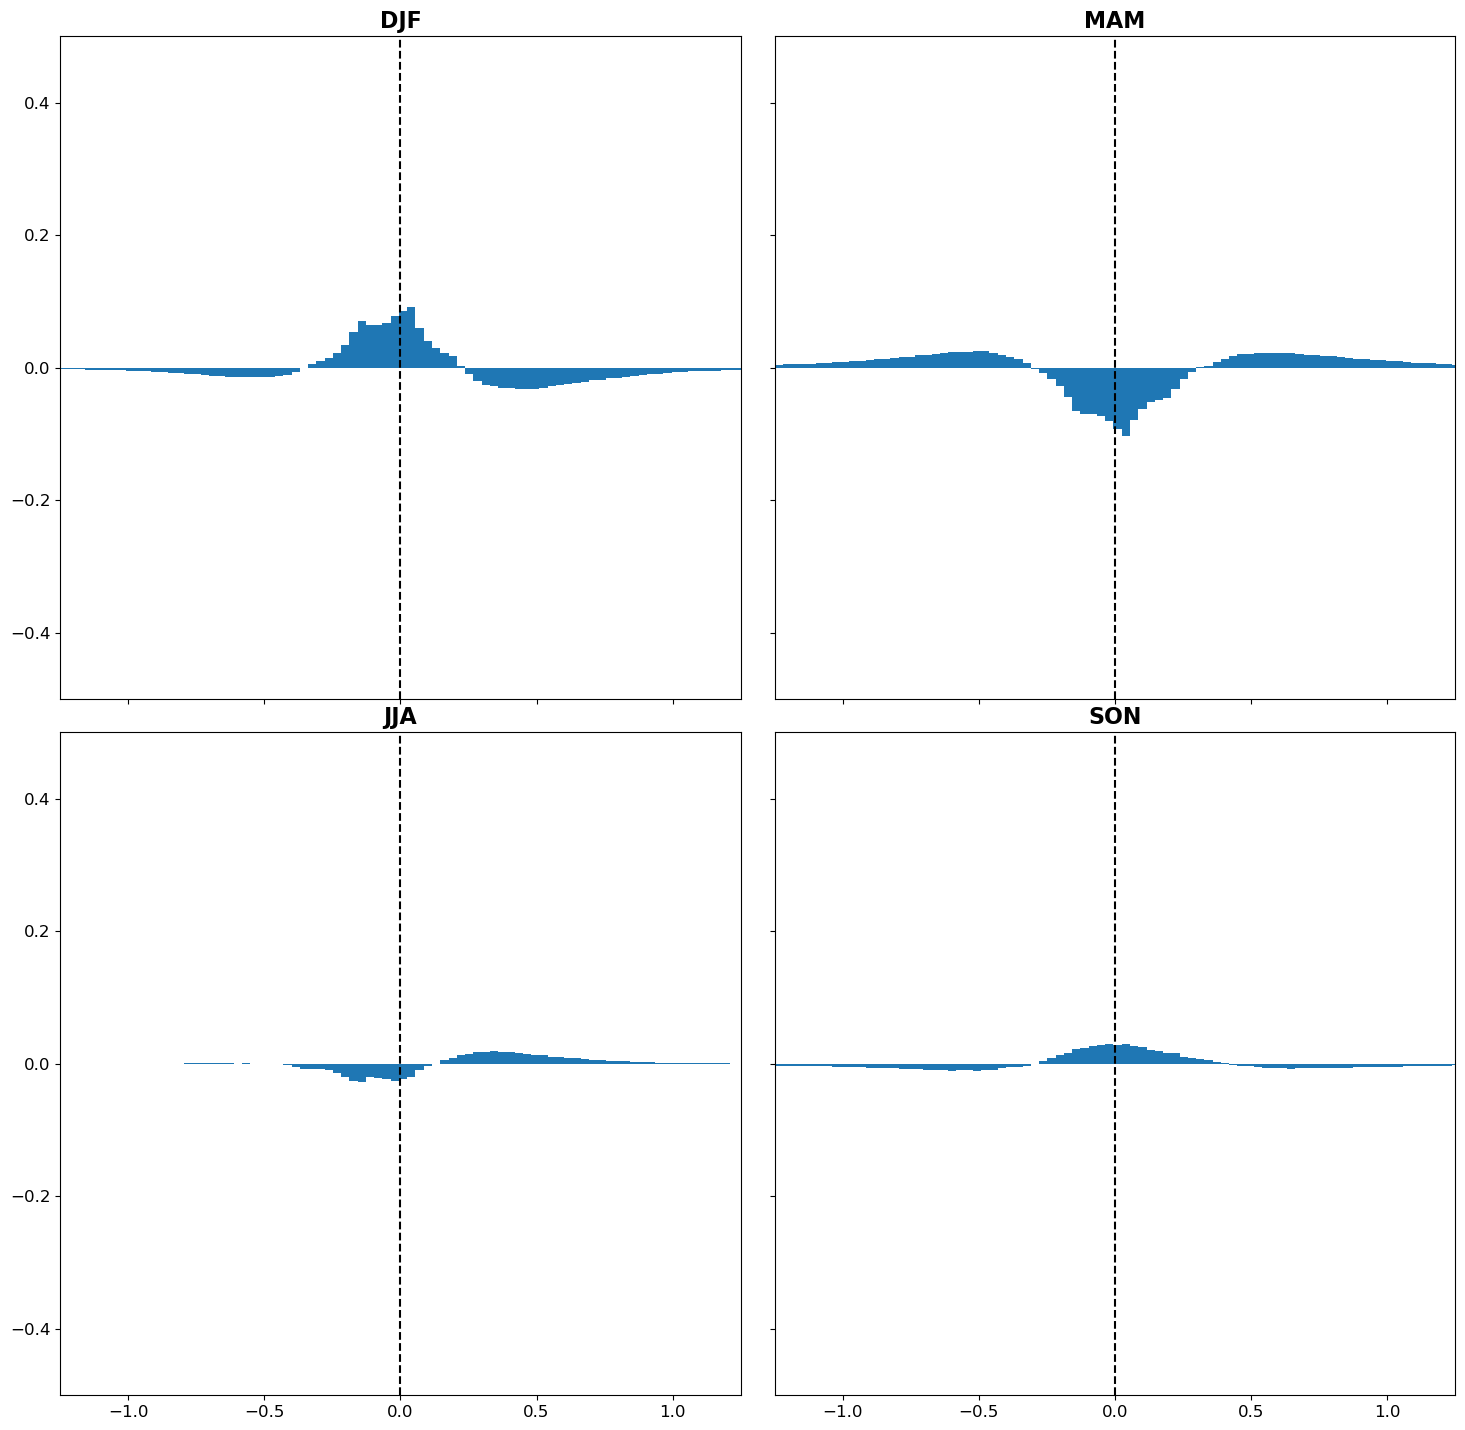

In [656]:
fig,host         = plt.subplots(2,2,  figsize=(1800/dpi,1800/dpi),dpi=dpi,sharex=True, sharey=True) # share the x axis, host is a list of axes for the subplot | # fig, host = plt.subplots(figsize=(3600/dpi,900/dpi),dpi=dpi)
# fig.patch.set_alpha(0)  # solution
import personal.plots
reload(personal.plots)

fig.subplots_adjust(hspace = 0.05) # remove height spacing between subplots
fig.subplots_adjust(wspace = 0.05 )

h = host.flatten()
for j in range(4):
    ax = h[j]
    ax.set_title(data_seas[j][0],weight='bold',size=16)
    personal.plots.hist_to_bar(ax, bin_edges=bins, count=out[j]-counts_all)
#     ax.hist(bins[:-1], bins, weights=out[j])
    ax.axvline(0, color='k', linestyle='--')
#     ax.set_ylim([0,1.75])
#     ax.set_xlim([-1.25,1.25])
    ax.set_ylim([-.5,.5])
    ax.set_xlim([-1.25,1.25])

In [568]:
data = vor['vorticity'].chunk({'time':24*7})
data = data.groupby('time.season')
data = personal.data_structures.reorder(list(data),[0,2,1,3])
g = data[2][1]
g.data

,Array,Chunk
Bytes,4.97 GB,44.84 MB
Shape,"(18617, 278, 240)","(168, 278, 240)"
Count,17747 Tasks,120 Chunks
Type,float32,numpy.ndarray


In [ ]:
h,_ = da.histogram(data[2][1].data*scaling,bins=bins,density=True)
h.compute()

In [672]:
g = data.mean('time',skipna=True).load()

In [ ]:
reload(personal.SMODE)
f,cax = personal.SMODE.SMODE_xr_plot(g*scaling,cmap=cm.get_cmap('RdBu', 2**6+1),vmin=-.5,vmax=.5)

In [743]:
client.restart()

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.93 GB


In [737]:
data_smoothed = data.chunk({'time':300})
data_smoothed = data_smoothed.rolling(time=24,center=True,min_periods=1).mean()
data_smoothed

,Array,Chunk
Bytes,19.65 GB,80.06 MB
Shape,"(73619, 278, 240)","(300, 278, 240)"
Count,24769 Tasks,247 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,588.95 kB,2.40 kB
Shape,"(73619,)","(300,)"
Count,18329 Tasks,246 Chunks
Type,datetime64[ns],numpy.ndarray


In [ ]:
data_smoothed_new = data_smoothed['vorticity'].chunk({'time':24*7})
# print(data_smoothed_new)
h_smoothed_new,_  = da.histogram(data_smoothed_new.data*scaling,bins=bins,density=True)
h_smoothed_new
h_smoothed_new = h_smoothed_new.compute()

In [776]:
h_smoothed_new

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [778]:
client.restart()

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.93 GB


In [ ]:
h_smoothed,_ = da.histogram(data_smoothed.data*scaling,bins=bins,density=True)
h_smoothed
h_smoothed = h.compute()

In [ ]:
h,_ = da.histogram(data_smoothed.data*scaling,bins=bins,density=True)
h
h = h.compute()

In [ ]:
h = counts_all

In [ ]:
fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
ax = plt.axes(facecolor=None)
personal.plots.hist_to_bar(ax, bin_edges=bins, count=h_smoothed_new)
ax.set_ylim([0,3])
ax.set_xlim([-1.25,1.25])

In [782]:
nbins = 600
bins  = np.linspace(dmin,dmax,num=nbins+1)

# data = vor['vorticity'].chunk({'time':24*7})
data_seas_smoothed = data_smoothed['vorticity'].groupby('time.season')
data_seas_smoothed = personal.data_structures.reorder(list(data_seas_smoothed),[0,2,1,3])

out = [[]]*4
for i,v in enumerate(data_seas_smoothed):
    out[i] = da.histogram(np.ravel(v[1].data)*scaling,bins=bins,density=True)[0].compute() # use the underlying dask arrays and dask.array.histogram to your advantage

(-1.25, 1.25)

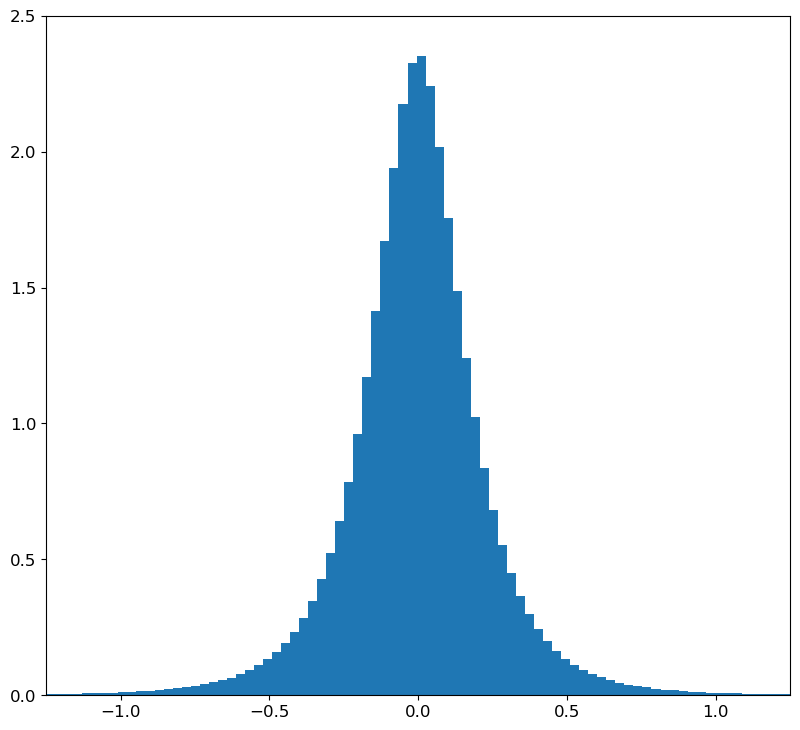

In [788]:
fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
ax = plt.axes(facecolor=None)
personal.plots.hist_to_bar(ax, bin_edges=bins, count=h_smoothed)
ax.set_ylim([0,2.5])
ax.set_xlim([-1.25,1.25])

In [ ]:
fig,host         = plt.subplots(2,2,  figsize=(1800/dpi,1800/dpi),dpi=dpi,sharex=True, sharey=True) # share the x axis, host is a list of axes for the subplot | # fig, host = plt.subplots(figsize=(3600/dpi,900/dpi),dpi=dpi)
# fig.patch.set_alpha(0)  # solution
import personal.plots
reload(personal.plots)

fig.subplots_adjust(hspace = 0.05) # remove height spacing between subplots
fig.subplots_adjust(wspace = 0.05 )

h = host.flatten()
for j in range(4):
    ax = h[j]
    ax.set_title(data_seas[j][0],weight='bold',size=16)
    personal.plots.hist_to_bar(ax, bin_edges=bins, count=out[j])
#     ax.hist(bins[:-1], bins, weights=out[j])
    ax.axvline(0, color='k', linestyle='--')
    ax.set_ylim([0,2.5])
    ax.set_xlim([-1.25,1.25])
#     ax.set_ylim([-.5,.5])
#     ax.set_xlim([-1.25,1.25])

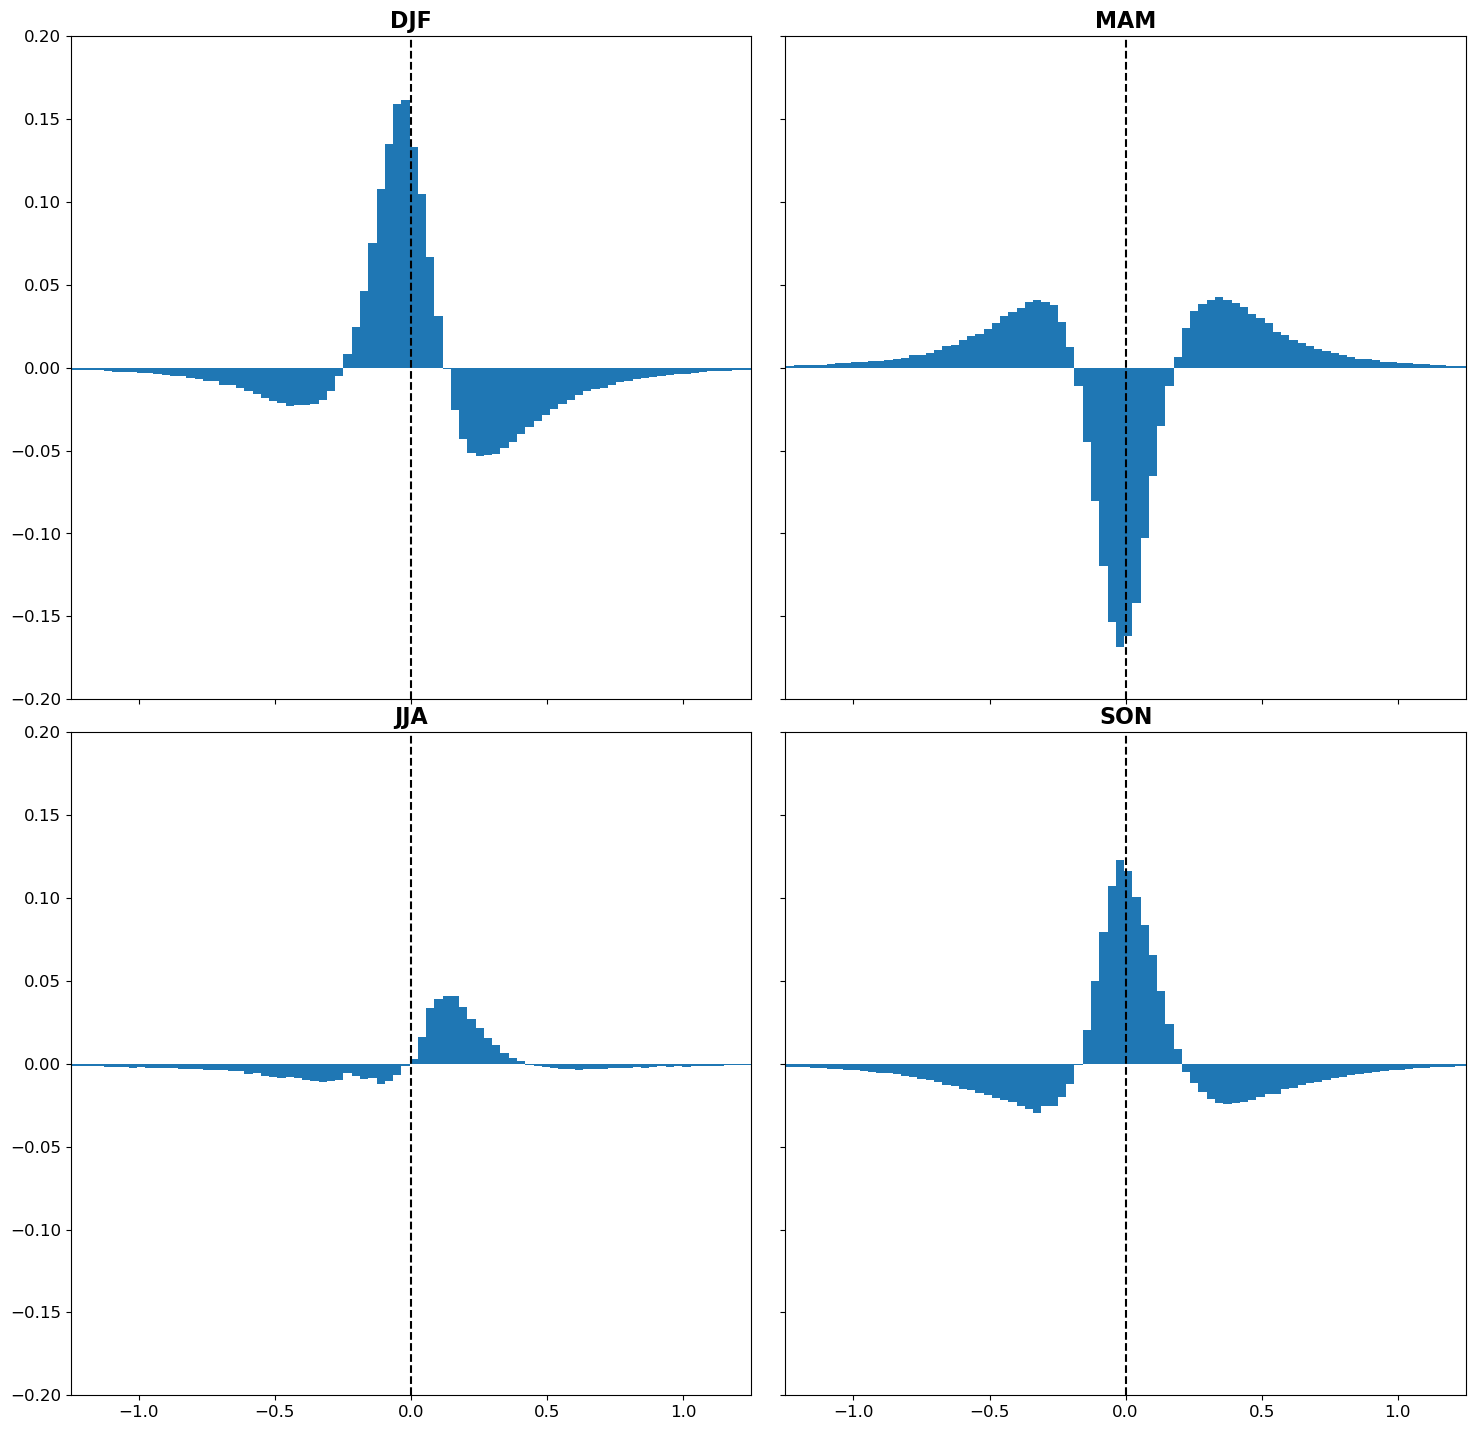

In [794]:
fig,host         = plt.subplots(2,2,  figsize=(1800/dpi,1800/dpi),dpi=dpi,sharex=True, sharey=True) # share the x axis, host is a list of axes for the subplot | # fig, host = plt.subplots(figsize=(3600/dpi,900/dpi),dpi=dpi)
# fig.patch.set_alpha(0)  # solution
import personal.plots
reload(personal.plots)

fig.subplots_adjust(hspace = 0.05) # remove height spacing between subplots
fig.subplots_adjust(wspace = 0.05 )

h = host.flatten()
for j in range(4):
    ax = h[j]
    ax.set_title(data_seas[j][0],weight='bold',size=16)
    personal.plots.hist_to_bar(ax, bin_edges=bins, count=out[j]-h_smoothed)
#     ax.hist(bins[:-1], bins, weights=out[j])
    ax.axvline(0, color='k', linestyle='--')
#     ax.set_ylim([0,2.5])
#     ax.set_xlim([-1.25,1.25])
    ax.set_ylim([-.2,.2])
    ax.set_xlim([-1.25,1.25])

(-1.25, 1.25)

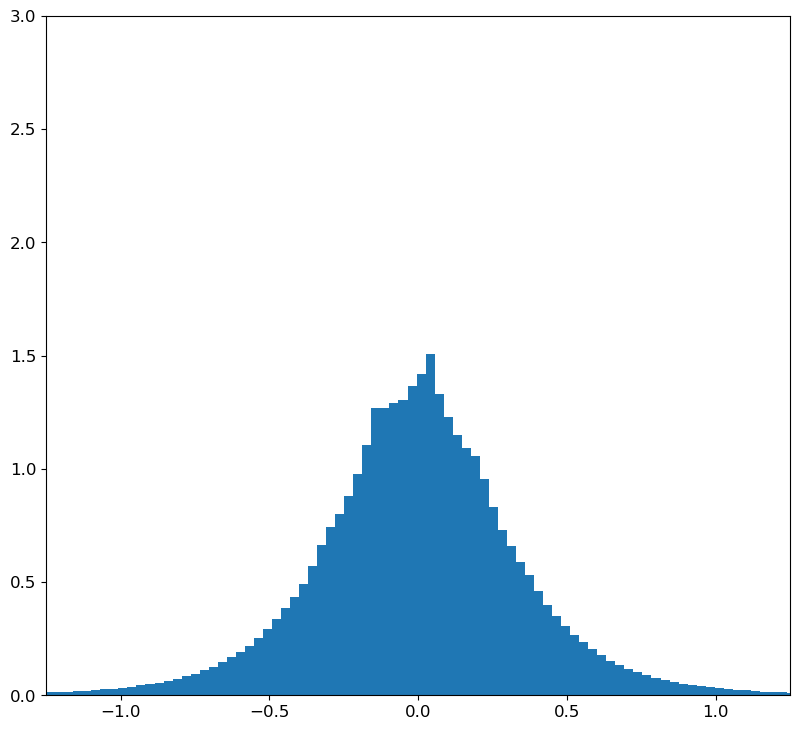

In [753]:
fig = plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
ax = plt.axes(facecolor=None)
personal.plots.hist_to_bar(ax, bin_edges=bins, count=counts_all)
ax.set_ylim([0,3])
ax.set_xlim([-1.25,1.25])

In [ ]:
h

In [2]:
client.restart()

NameError: name 'client' is not defined

In [249]:
file_path        = os.path.abspath(os.path.dirname(''))
data_relpath     = "../Data/HF_Radar/2km/processed/smode_region/"
data_source      = os.path.normpath(os.path.join(file_path, data_relpath))
data_source      = os.path.normpath(os.path.join(file_path, data_relpath))

time_chunk_here = 300

data_smoothed = xr.open_mfdataset(data_source+'/gradients/smoothed/*.nc', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override").chunk({'time':time_chunk_here,'deriv':1})
data_smoothed['vorticity' ]         = data_smoothed['gradients'][:,:,:,2] - data_smoothed['gradients'][:,:,:,1] # dv/dx - du/dy
data_smoothed = data_smoothed.drop('gradients')

KeyboardInterrupt: 

In [ ]:
h = data_smoothed['vorticity'].to_dataset()
h_mp = h.metpy.parse_cf() #.parse_cf() for getting x,y

dims ={'t':0,'y':1,'x':2}
dx, dy = mpcalc.grid_deltas_from_dataarray(h_mp['vorticity'])
y      = pm.dq_to_q(np.array(dy),dims['y'])
y      = np.squeeze(y)
#y      = np.repeat(y,smode_data['u'.shape[dims['t']],dims['t']) #expand to full arrays
x      = pm.dq_to_q(np.array(dx),dims['x'])
x      = np.squeeze(x)

print(x[:5,:5])
print(y[:5,:5])

In [ ]:
f = h['vorticity'].data
f
# f = f.compute()

In [248]:
client.restart()

KeyboardInterrupt: 

In [ ]:
slices = ([220,225],[120,125],[20000,30000])
d = h['vorticity'].data.transpose([1,2,0])[slices[0][0]:slices[0][1],slices[1][0]:slices[1][1],slices[2][0]:slices[2][1]] # move coordinates to first,

d = d.reshape(-1, *d.shape[-1:]).rechunk({0:1,1:-1})  # then flatten to list along coords (flatten all but last dim time), then rechunk along time for quick access later...
# print((x,y))
coords = np.stack((x[slices[0][0]:slices[0][1],slices[1][0]:slices[1][1]].flatten(), y[slices[0][0]:slices[0][1],slices[1][0]:slices[1][1]].flatten()),axis=1)

print(d)
print(d.shape)
# print(d.compute())
print(coords)

In [240]:
d.compute()

KeyboardInterrupt: 

In [236]:
reload(personal.calculations)
# m = personal.calculations.structure_function(d.compute(),coords)
m = personal.calculations.structure_function(d,coords)
m

25
300
structfun_data
-----
groups
None
mapping
300
mapping unraveled
[ 1829.63406775  3659.93857672  5489.57264447  7319.20671223
  1996.2776603   2671.17331773  4120.90995711  5789.48242226
  7533.00545734  3992.56201575  4346.61839078  5342.18881439
  6698.59347507  8239.65526643  5989.2766393   6215.01781863
  6933.35902097  8012.46389795  9328.0765724   7985.57438957
  8144.13532449  8693.16687557  9565.31528205 10681.82664286
  1830.30450896  3659.93857672  5489.57264447  2743.83290913
  1996.28967763  2671.32229052  4120.51958743  5789.06358753
  4436.22125937  3992.58606012  4346.53029595  5341.59556961
  6697.87667806  6309.2849285   5989.31272295  6214.83828856
  6932.68375997  8011.57398397  8240.219156    7985.62251965
  8143.91427233  8692.45990665  9564.33147936  1829.63406775
  3659.26813551  4215.71039185  2744.59940124  1996.30179908
  2670.58010273  4119.54268781  5488.14531868  4436.9038413
  3992.61031279  4345.91152672  5340.55690316  7102.3209017
  6309.91917594  

1827.848170     dask.array<mean_agg-aggregate, shape=(), dtype...
1828.294892     dask.array<mean_agg-aggregate, shape=(), dtype...
1828.517957     dask.array<mean_agg-aggregate, shape=(), dtype...
1828.741528     dask.array<mean_agg-aggregate, shape=(), dtype...
1828.964842     dask.array<mean_agg-aggregate, shape=(), dtype...
                                      ...                        
9580.958217     dask.array<mean_agg-aggregate, shape=(), dtype...
9811.108566     dask.array<mean_agg-aggregate, shape=(), dtype...
9812.146942     dask.array<mean_agg-aggregate, shape=(), dtype...
10681.826643    dask.array<mean_agg-aggregate, shape=(), dtype...
10976.223529    dask.array<mean_agg-aggregate, shape=(), dtype...
Length: 280, dtype: object

In [237]:
m.iloc[0:5]

1827.848170    dask.array<mean_agg-aggregate, shape=(), dtype...
1828.294892    dask.array<mean_agg-aggregate, shape=(), dtype...
1828.517957    dask.array<mean_agg-aggregate, shape=(), dtype...
1828.741528    dask.array<mean_agg-aggregate, shape=(), dtype...
1828.964842    dask.array<mean_agg-aggregate, shape=(), dtype...
dtype: object

In [239]:
m.iloc[0:1].apply(lambda x: x.compute())

KeyboardInterrupt: 